# Projet 7 : Élaborer un modèle de scoring

**Modélisation**

# I. Importer les librairies & les données

## A. Les librairies

In [3]:
# Librairies de base python 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import table
import missingno as msno
import gc
import time
from contextlib import contextmanager
import os
import warnings
from tqdm import tqdm
import joblib

# Librairies sklearn
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

# Modèles de classifieurs
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

# Tracking 
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import mlflow
import subprocess
import webbrowser

# Push gitbuh
import shutil

# Pytest / Test unitaire
import pytest

# Gestion déséquilibrage de la target
from imblearn.under_sampling import RandomUnderSampler

# Recherche des hyperparamètres avec Optuna
import optuna

# Explicabilité du modèle
import shap

Vérification système & environnement virtuel :

In [4]:
# Vérifier le répertoire de travail actuel
print("Current working directory:", os.getcwd())
import sys
print("Environnement exécuté", sys.executable)

Current working directory: C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°7\Projet n°7_Scoring
Environnement exécuté C:\Users\justi\anaconda3\envs\env_scoring_model\python.exe


## B. Les données

In [3]:
df = pd.read_csv('df_mod.csv')

In [4]:
# Supprimer la colonne 
df = df.drop('Unnamed: 0', axis=1)
df.shape

(307507, 130)

<Axes: >

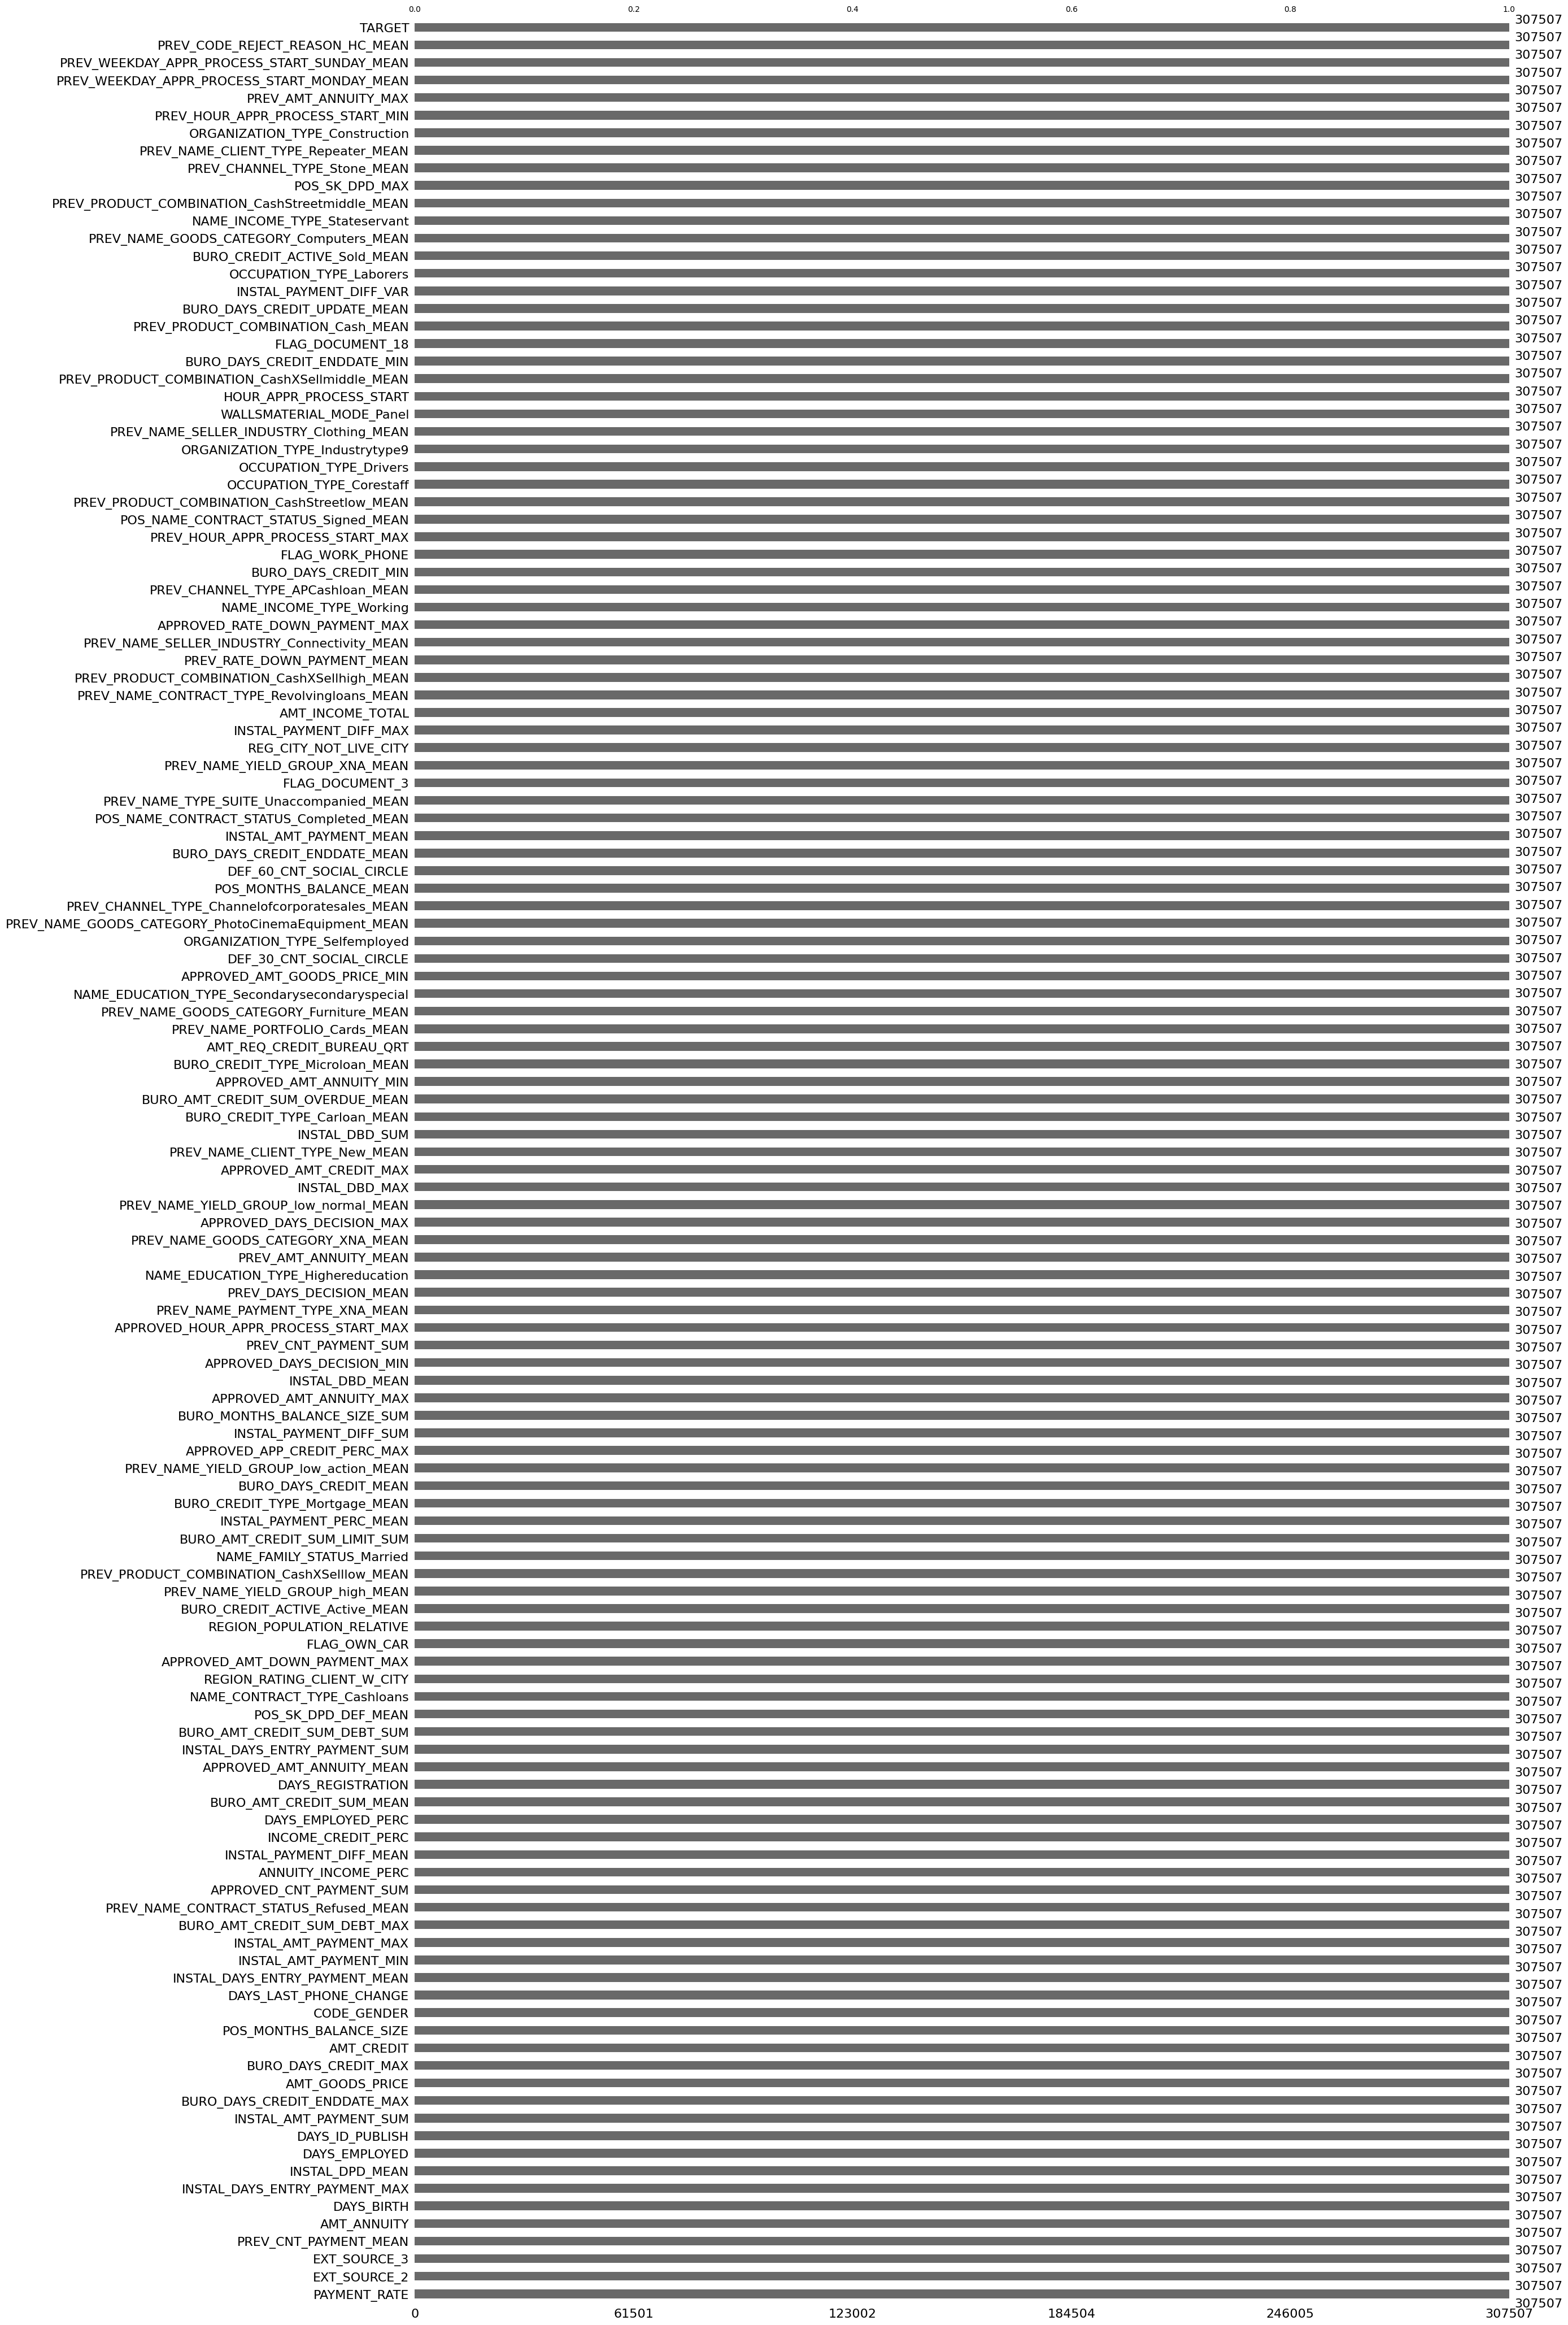

In [5]:
msno.bar(df)

## C. MlFlow

### 1. Initialisation de l'expérience MLFlow et accès à l'interface

In [5]:
# Définir l'URI de suivi vers le répertoire de travail correct
mlflow.set_tracking_uri(r"file:///C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°7\Projet n°7_Scoring\mlruns")

# Fonction d'initialisation de l'environnement MLflow
def initialize_mlflow(experiment_name):
    # Définir l'expérience
    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)
    print("Initialized MLflow environment.")
    print(f"Experiment Name: {experiment_name}")
    print(f"Experiment ID: {experiment.experiment_id}")

# Initialisation de l'environnement MLflow avec un nom d'expérience
experiment_name = "Projetn7_OC"
initialize_mlflow(experiment_name)

Initialized MLflow environment.
Experiment Name: Projetn7_OC
Experiment ID: 833895289269179369


In [6]:
# Définir le chemin
mlflow_path = r'C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°7\Projet n°7_Scoring\mlruns'

# Lancer MLflow UI
try:
    subprocess.Popen(
        f'mlflow ui --backend-store-uri "file:///{mlflow_path}"',
        shell=True
    )
    print("MLflow UI started successfully.")
except Exception as e:
    print(f"Error starting MLflow UI: {e}")

MLflow UI started successfully.


In [7]:
# Ouvrir l'URL MLflow dans le navigateur par défaut
url = "http://localhost:5000"
webbrowser.open(url)

True

### 2. Enregistrer le modèle dans "model registry"

In [8]:
# Chargement du modèle depuis un fichier .pkl
model = joblib.load('best_model.pkl')

In [ ]:
import mlflow
import mlflow.pyfunc

# Démarrer une nouvelle expérience
mlflow.set_experiment("mon_experience")

# Enregistrez le modèle dans MLflow
with mlflow.start_run():
    # Enregistrer le modèle avec MLflow en utilisant une classe de prédiction personnalisée
    class ModelWrapper(mlflow.pyfunc.PythonModel):
        def load_context(self, context):
            # Charger le modèle depuis le fichier .pkl
            self.model = joblib.load('votre_modele.pkl')

        def predict(self, context, model_input):
            # Effectuer des prédictions avec le modèle
            return self.model.predict(model_input)

    # Enregistrer le modèle dans MLflow
    mlflow.pyfunc.log_model(
        artifact_path="modele_mlflow",
        python_model=ModelWrapper()
    )


# III. Modélisation

## A. Gestion du déséquilibrage de la target & création d'un score métier

Nous sommes dans la situation où notre cible, 'TARGET', est fortement déséquilibrée. Effectivement, la proportion est de 8.1% pour la classe 1 et et de 91.9% pour la classe 0. 
Lors d'une classification, il est important de prendre en compte ce déséquilibrage car cela peut entrainer les conséquences suivantes : 
- Biais du modèle vers la classe majoritaire
- Métriques d'évaluation trompeuses
- Sous apprentissage de la classe minoritaire

Plusieurs méthodes s'offrent à nous pour régulariser ce problème, les voici : 
- Le sous-échantillonage ( suppression d'observations de la majoritaire --> Perte d'information)
- Le sur-échantillonge (avec la création de doublons synthétique de la classe minoritaire "SMOTE" --> risque d'overfitting)
- La méthode scikit-learn "class_weight" ( gère les déséquilibres de classes en modifiant l'importance que le modèle accorde à chaque classe, afin de compenser les effets négatifs liés à un déséquilibre entre les classes.)

### 1. Gestion du déséquilibrage de la target

In [9]:
df1 = df.copy()

#### a. Sous-échantillonage 

Script de la fonction :

In [10]:
def balance_data_undersample(df, target_column):
    """
    Équilibre les données en utilisant le sous-échantillonnage RandomUnderSampler.

    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    target_column (str): Le nom de la colonne cible (target).

    Returns:
    pd.DataFrame: Le DataFrame équilibré.
    """
    # Séparer les caractéristiques et la target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Appliquer RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    # Créer un nouveau DataFrame avec les données équilibrées
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled

    return df_resampled

Exécution de la fonction :

In [11]:
dfss = balance_data_undersample(df1, 'TARGET')

In [12]:
dfss['TARGET'].value_counts()

TARGET
0.0    24825
1.0    24825
Name: count, dtype: int64

In [13]:
# format CSV du dataframe
dfss.to_csv('dfss.csv', index = True)

#### b. Sur-échantillonage (SMOTE)

In [26]:
df2 = pd.read_csv('df_mod.csv')

Script de la fonction : 

In [27]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def balance_data_smote(df, target_column, sampling_strategy='auto', random_state=42, k_neighbors=2, n_jobs=None):
    """
    Équilibre les données en utilisant le sur-échantillonnage SMOTE avec normalisation préalable.

    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    target_column (str): Le nom de la colonne cible (target).
    sampling_strategy (str or dict): La stratégie d'échantillonnage. Default='auto'.
    random_state (int): Le seed pour la reproductibilité. Default=42.
    k_neighbors (int): Le nombre de voisins à utiliser pour la génération des échantillons synthétiques. Default=5.
    n_jobs (int or None): Le nombre de jobs à utiliser pour le calcul. Default=None.

    Returns:
    pd.DataFrame: Le DataFrame équilibré.
    """
    # Séparer les caractéristiques et la target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Normaliser les données continues
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Appliquer SMOTE avec hyperparamètres
    smote = SMOTE(sampling_strategy=sampling_strategy, 
                  random_state=random_state, 
                  k_neighbors=k_neighbors, 
                  n_jobs=n_jobs)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    # Créer un nouveau DataFrame avec les données équilibrées
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled

    return df_resampled

Exécution du script : 

In [28]:
dfsr = balance_data_smote(df2, 'TARGET')

In [29]:
dfsr['TARGET'].value_counts()

TARGET
1.0    282682
0.0    282682
Name: count, dtype: int64

In [30]:
# format CSV du dataframe
dfsr.to_csv('dfsr.csv', index = True)

### 2. Score métier

Pondération selon le résultat obtenus par le classifier, avec la création d'un score métier pour notamment appuyer le poids des faux-négatifs qui représentent plus de risque pour la banque, qu'un faux positif. 

In [18]:
def score_metier(y, y_pred):
    tn = np.sum((y_pred == 0) & (y == 0)) * 3
    fn = np.sum((y_pred == 0) & (y == 1)) * -10
    fp = np.sum((y_pred == 1) & (y == 0)) * -1
    tp = np.sum((y_pred == 1) & (y == 1)) * 0  
    total_profit = tn + fn + fp + tp
    n = len(y)
    return total_profit / n

Poids donnés aux différents cas
- True Negative (tn) : Poids de 3
- False Negative (fn) : Poids de -10
- False Positive (fp) : Poids de -1
- True Positive (tp) : Poids de 0

## C. Modélisation / Classification

Nous allons utiliser Pycaret pour lancer plusieurs modèles de classifier. 
L'objectif sera de sélectionner les meilleurs modèles pour la metrique AUC, que nous essayerons d'optimiser via les hyperparamètres avec Optuna. 
Deux modélisations seront lancées, avec des approches différentes pour la gestion de déséquilibrage de notre target.
Nous aurons du sous-échantillonage, puis du sur-échantillonage avec SMOTE.
Le souhait initial était d'intégrer directement le score métier dans cette modélisation avec Pycaret, toutefois l'application souffre d'un dysfonctionnement qui ne permet plus d'utiliser la fonction "add metric".
C'est en ce sens que je fais cette modélisation en deux temps, avec une préselectionen utilisant l'AUC, puis ensuite le score métier sur les 3 business score. 

### 1. Sous-échantillonage

In [9]:
df = pd.read_csv('dfss.csv')

In [11]:
# Ignorer les avertissements de distutils et setuptools
warnings.filterwarnings("ignore", message="Distutils was imported before Setuptools")
warnings.filterwarnings("ignore", message="Setuptools is replacing distutils")

# Démarrer une nouvelle expérience MLflow
mlflow.set_experiment("Projetn7_OC")

# Fonction personnalisée pour calculer le BusinessScore
def score_metier(y, y_pred):
    tn = np.sum((y_pred == 0) & (y == 0)) * 3
    fn = np.sum((y_pred == 0) & (y == 1)) * -10
    fp = np.sum((y_pred == 1) & (y == 0)) * -1
    tp = np.sum((y_pred == 1) & (y == 1)) * 0  
    total_profit = tn + fn + fp + tp
    n = len(y)
    return total_profit / n

# Initialisation des classifieurs
classifiers = {
    'DummyClassifier': DummyClassifier(strategy="most_frequent"),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(),
    'LightGBM': lgb.LGBMClassifier(force_col_wise=True)
}

# Séparation des caractéristiques et de la cible
X = df.drop(columns=['TARGET']).astype(np.float64)  
y = df['TARGET']

# Séparation du jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# DataFrame pour stocker les résultats
results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'AUC', 'Precision', 'Recall', 'Execution Time', 'BusinessScore'])

# Exemple d'entrée pour l'inférence de la signature du modèle
input_example = X_train.head(1)

# Boucle pour entraîner chaque modèle, faire des prédictions et calculer les métriques
for name, clf in tqdm(classifiers.items(), desc="Training Classifiers", unit="classifier"):
    run_name = f"{name} + sous-échantillonage"
    with mlflow.start_run(run_name=run_name):
        # Création de la pipeline avec normalisation et classifieur
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])
        
        # Enregistrement des hyperparamètres du modèle dans MLflow
        mlflow.log_params(clf.get_params())
        
        # Entraînement et calcul du temps d'exécution
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        execution_time = time.time() - start_time
        
        # Prédiction
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else y_pred
        
        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred, zero_division=1)  # Gestion de la division par zéro
        recall = recall_score(y_test, y_pred)
        business_score = score_metier(y_test, y_pred)
        
        # Log des métriques dans MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("execution_time", execution_time)
        mlflow.log_metric("business_score", business_score)
        
        # Log du modèle dans MLflow avec exemple d'entrée
        mlflow.sklearn.log_model(pipeline, "model", input_example=input_example)
        
        # Création d'un DataFrame
        result = pd.DataFrame({
            'Classifier': [name],
            'Accuracy': [accuracy],
            'AUC': [auc],
            'Precision': [precision],
            'Recall': [recall],
            'Execution Time': [execution_time],
            'BusinessScore': [business_score]
        })
        
        # Vérification si le DataFrame temporaire est vide
        if not result.dropna(how='all').empty:
            results = pd.concat([results, result.dropna(how='all')], ignore_index=True)


Training Classifiers:   0%|          | 0/6 [00:00<?, ?classifier/s]

C:\Users\justi\AppData\Local\Temp\ipykernel_10564\4007760069.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result.dropna(how='all')], ignore_index=True)
Training Classifiers:  17%|█▋        | 1/6 [00:05<00:25,  5.17s/classifier]

Training Classifiers:  33%|███▎      | 2/6 [00:37<01:24, 21.02s/classifier]

Training Classifiers:  50%|█████     | 3/6 [01:54<02:19, 46.52s/classifier]C:\Users\justi\anaconda3\envs\env_scoring_model\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Training Classifiers:  67%|██████▋   | 4/6 [01:59<01:00, 30.10s/classifier]

Training Classifiers:  83%|████████▎ | 5/6 [02:03<00:20, 20.92s/classifier]

[LightGBM] [Info] Number of positive: 17366, number of negative: 17389
[LightGBM] [Info] Total Bins 20446
[LightGBM] [Info] Number of data points in the train set: 34755, number of used features: 130
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499669 -> initscore=-0.001324
[LightGBM] [Info] Start training from score -0.001324


Training Classifiers: 100%|██████████| 6/6 [02:09<00:00, 21.53s/classifier]


In [12]:
results

,Classifier,Accuracy,AUC,Precision,Recall,Execution Time,BusinessScore
0,DummyClassifier,0.499228,0.500000,1.000000,0.000000,0.075279,-3.510037
1,RandomForest,0.685532,0.747390,0.689731,0.676230,25.936136,-0.732998
2,GradientBoosting,0.696475,0.765039,0.693953,0.704652,72.146243,-0.603827
3,XGBoost,0.689225,0.755720,0.687765,0.694865,0.870975,-0.662236
4,LogisticRegression,0.690433,0.759888,0.688210,0.698083,0.328291,-0.647734
5,LightGBM,0.706009,0.771849,0.706822,0.705591,0.752434,-0.562873


### 2. Sur-échantillonnage

In [14]:
df = pd.read_csv('dfsr.csv')

In [15]:
# Ignorer les avertissements de distutils et setuptools
warnings.filterwarnings("ignore", message="Distutils was imported before Setuptools")
warnings.filterwarnings("ignore", message="Setuptools is replacing distutils")

# Démarrer une nouvelle expérience MLflow
mlflow.set_experiment("Projetn7_OC")

# Fonction personnalisée pour calculer le BusinessScore
def score_metier(y, y_pred):
    tn = np.sum((y_pred == 0) & (y == 0)) * 3
    fn = np.sum((y_pred == 0) & (y == 1)) * -10
    fp = np.sum((y_pred == 1) & (y == 0)) * -1
    tp = np.sum((y_pred == 1) & (y == 1)) * 0  
    total_profit = tn + fn + fp + tp
    n = len(y)
    return total_profit / n

# Initialisation des classifieurs
classifiers = {
    'DummyClassifier': DummyClassifier(strategy="most_frequent"),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'LogisticRegression': LogisticRegression(),
    'LightGBM': lgb.LGBMClassifier(force_col_wise=True)
}

# Séparation des caractéristiques et de la cible
X = df.drop(columns=['TARGET']).astype(np.float64)  
y = df['TARGET']

# Séparation du jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# DataFrame pour stocker les résultats
results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'AUC', 'Precision', 'Recall', 'Execution Time', 'BusinessScore'])

# Exemple d'entrée pour l'inférence de la signature du modèle
input_example = X_train.head(1)

# Boucle pour entraîner chaque modèle, faire des prédictions et calculer les métriques
for name, clf in tqdm(classifiers.items(), desc="Training Classifiers", unit="classifier"):
    run_name = f"{name} + sur-échantillonage"
    with mlflow.start_run(run_name=run_name):
        # Création de la pipeline avec normalisation et classifieur
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])
        
        # Enregistrement des hyperparamètres du modèle dans MLflow
        mlflow.log_params(clf.get_params())
        
        # Entraînement et calcul du temps d'exécution
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        execution_time = time.time() - start_time
        
        # Prédiction
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else y_pred
        
        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred, zero_division=1)  # Gestion de la division par zéro
        recall = recall_score(y_test, y_pred)
        business_score = score_metier(y_test, y_pred)
        
        # Log des métriques dans MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("execution_time", execution_time)
        mlflow.log_metric("business_score", business_score)
        
        # Log du modèle dans MLflow avec exemple d'entrée
        mlflow.sklearn.log_model(pipeline, "model", input_example=input_example)
        
        # Création d'un DataFrame
        result = pd.DataFrame({
            'Classifier': [name],
            'Accuracy': [accuracy],
            'AUC': [auc],
            'Precision': [precision],
            'Recall': [recall],
            'Execution Time': [execution_time],
            'BusinessScore': [business_score]
        })
        
        # Vérification si le DataFrame temporaire est vide
        if not result.dropna(how='all').empty:
            results = pd.concat([results, result.dropna(how='all')], ignore_index=True)


Training Classifiers:   0%|          | 0/6 [00:00<?, ?classifier/s]

C:\Users\justi\AppData\Local\Temp\ipykernel_10564\2043621796.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result.dropna(how='all')], ignore_index=True)
Training Classifiers:  17%|█▋        | 1/6 [00:05<00:28,  5.74s/classifier]

Training Classifiers:  33%|███▎      | 2/6 [06:47<15:53, 238.50s/classifier]

Training Classifiers:  50%|█████     | 3/6 [26:17<33:11, 663.90s/classifier]C:\Users\justi\anaconda3\envs\env_scoring_model\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Training Classifiers:  67%|██████▋   | 4/6 [26:29<13:32, 406.46s/classifier]

Training Classifiers:  83%|████████▎ | 5/6 [26:37<04:22, 262.89s/classifier]

[LightGBM] [Info] Number of positive: 197786, number of negative: 197968
[LightGBM] [Info] Total Bins 32559
[LightGBM] [Info] Number of data points in the train set: 395754, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499770 -> initscore=-0.000920
[LightGBM] [Info] Start training from score -0.000920


Training Classifiers: 100%|██████████| 6/6 [26:48<00:00, 268.13s/classifier]


In [16]:
results

,Classifier,Accuracy,AUC,Precision,Recall,Execution Time,BusinessScore
0,DummyClassifier,0.499463,0.500000,1.000000,0.000000,1.001195,-3.506975
1,RandomForest,0.955905,0.982765,0.999910,0.911986,383.777782,1.057685
2,GradientBoosting,0.955928,0.978849,0.999806,0.912128,1163.027709,1.058204
3,XGBoost,0.955669,0.979762,0.994542,0.916462,6.384923,1.070185
4,LogisticRegression,0.955645,0.978673,0.998659,0.912611,3.271211,1.058522
5,LightGBM,0.955928,0.980076,0.997532,0.914213,5.522711,1.064466


### 3. Utilisation de "class_weight"

In [19]:
df = pd.read_csv('df_mod.csv')
df = df.drop('Unnamed: 0', axis=1)
print('Structure du dataframe', df.shape)

Structure du dataframe (307507, 130)


In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin

# Classe custom pour ajouter class_weight
class ClassWeightWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, class_weight='balanced'):
        self.base_estimator = base_estimator
        self.class_weight = class_weight
    
    def fit(self, X, y):
        # Ajouter class_weight 
        if hasattr(self.base_estimator, 'class_weight'):
            self.base_estimator.set_params(class_weight=self.class_weight)
        self.base_estimator.fit(X, y)
        return self
    
    def predict(self, X):
        return self.base_estimator.predict(X)
    
    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)
    
    def get_params(self, deep=True):
        return {"base_estimator": self.base_estimator, "class_weight": self.class_weight}
    
    def set_params(self, **params):
        self.base_estimator.set_params(**params)
        return self

# Modification des classifieurs pour utiliser le wrapper
classifiers = {
    'DummyClassifier': DummyClassifier(strategy="most_frequent"),
    'RandomForest': ClassWeightWrapper(RandomForestClassifier()),
    'GradientBoosting': ClassWeightWrapper(GradientBoostingClassifier()),
    'XGBoost': ClassWeightWrapper(xgb.XGBClassifier(eval_metric='logloss')),
    'LogisticRegression': ClassWeightWrapper(LogisticRegression()),
    'LightGBM': ClassWeightWrapper(lgb.LGBMClassifier(force_col_wise=True))
}

# Boucle pour entraîner chaque modèle, faire des prédictions et calculer les métriques
for name, clf in tqdm(classifiers.items(), desc="Training Classifiers", unit="classifier"):
    run_name = f"{name} + class_weight"
    with mlflow.start_run(run_name=run_name):
        # Création de la pipeline avec normalisation et classifieur
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', clf)
        ])
        
        # Enregistrement des hyperparamètres du modèle dans MLflow
        mlflow.log_params(clf.get_params())
        
        # Entraînement et calcul du temps d'exécution
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        execution_time = time.time() - start_time
        
        # Prédiction
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else y_pred
        
        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred, zero_division=1)  # Gestion de la division par zéro
        recall = recall_score(y_test, y_pred)
        business_score = score_metier(y_test, y_pred)
        
        # Log des métriques dans MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("execution_time", execution_time)
        mlflow.log_metric("business_score", business_score)
        
        # Log du modèle dans MLflow avec exemple d'entrée
        mlflow.sklearn.log_model(pipeline, "model", input_example=input_example)
        
        # Création d'un DataFrame
        result = pd.DataFrame({
            'Classifier': [name],
            'Accuracy': [accuracy],
            'AUC': [auc],
            'Precision': [precision],
            'Recall': [recall],
            'Execution Time': [execution_time],
            'BusinessScore': [business_score]
        })
        
        # Vérification si le DataFrame temporaire est vide
        if not result.dropna(how='all').empty:
            results = pd.concat([results, result.dropna(how='all')], ignore_index=True)


Training Classifiers:   0%|          | 0/6 [00:00<?, ?classifier/s]

Training Classifiers:  17%|█▋        | 1/6 [00:05<00:28,  5.61s/classifier]

Training Classifiers:  33%|███▎      | 2/6 [06:29<15:12, 228.05s/classifier]

Training Classifiers:  50%|█████     | 3/6 [44:24<58:08, 1162.93s/classifier]C:\Users\justi\anaconda3\envs\env_scoring_model\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Training Classifiers:  67%|██████▋   | 4/6 [44:58<23:53, 716.99s/classifier] 

Training Classifiers:  83%|████████▎ | 5/6 [45:11<07:43, 463.43s/classifier]

[LightGBM] [Info] Number of positive: 197786, number of negative: 197968
[LightGBM] [Info] Total Bins 32559
[LightGBM] [Info] Number of data points in the train set: 395754, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Training Classifiers: 100%|██████████| 6/6 [45:39<00:00, 456.52s/classifier]


In [23]:
results

,Classifier,Accuracy,AUC,Precision,Recall,Execution Time,BusinessScore
0,DummyClassifier,0.499463,0.500000,1.000000,0.000000,1.001195,-3.506975
1,RandomForest,0.955905,0.982765,0.999910,0.911986,383.777782,1.057685
2,GradientBoosting,0.955928,0.978849,0.999806,0.912128,1163.027709,1.058204
3,XGBoost,0.955669,0.979762,0.994542,0.916462,6.384923,1.070185
4,LogisticRegression,0.955645,0.978673,0.998659,0.912611,3.271211,1.058522
5,LightGBM,0.955928,0.980076,0.997532,0.914213,5.522711,1.064466
6,DummyClassifier,0.499463,0.500000,1.000000,0.000000,0.960518,-3.506975
7,DummyClassifier,0.499463,0.500000,1.000000,0.000000,1.022381,-3.506975
8,RandomForest,0.955899,0.981865,0.999948,0.911939,359.255622,1.057520
9,GradientBoosting,0.955928,0.978848,0.999806,0.912128,2266.789219,1.058204


In [ ]:
##### -------> sélection du LightGBM avec sous-échantillonage, meilleur modèle sans overfitting, avec une AUC 0.77 & business score à -0.562

### 4. Cross-validation & optimisation des hyper-paramètres du modèle sélectionné (Optuno)

Suite à l'ensemble des modélisations effectuées en amont, mon choix se porte sur le LightGBM, avec une technique de sous-échantillonage dans la gestion du déséquilibrage de la target.
Nous allons dans cette partie le tester sur une cross validation puis sur tenter d'optimiser les hyperparamètres pour atteindre un business score le plus performant qu'il est possible.

#### i. Test LGBM seul avec cross-validation ----> Overfitting ?

In [9]:
dflgbm = pd.read_csv('dfss.csv')

In [10]:
dflgbm = dflgbm.drop('Unnamed: 0', axis=1)
dflgbm.shape

(49650, 130)

[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20085
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499685 -> initscore=-0.001259
[LightGBM] [Info] Start training from score -0.001259
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20126
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499685 -> initscore=-0.001259
[LightGBM] [Info] Start training from score -0.001259
[LightGB

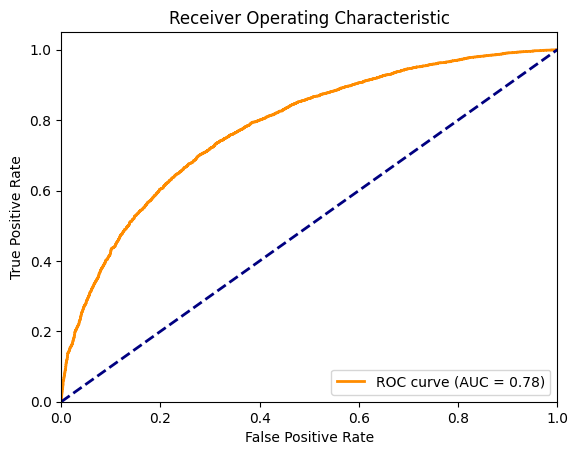

In [11]:
# Démarrer une nouvelle expérimentation MLflow
mlflow.set_experiment('Projetn7_OC')

# Supposons que votre DataFrame s'appelle df et que votre target soit 'TARGET'
X = dflgbm.drop(columns=['TARGET'])
y = dflgbm['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer la pipeline avec StandardScaler et LightGBM
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Étape de normalisation
    ('classifier', lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42))
])

# Enregistrer dans un run MLflow avec un nom spécifique
with mlflow.start_run(run_name="LightGBM - CV"):
    # Effectuer une validation croisée
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    mean_cv_score = cv_scores.mean()
    
    # Loguer les métriques de validation croisée
    mlflow.log_metric('mean_cv_auc', mean_cv_score)
    for i, score in enumerate(cv_scores):
        mlflow.log_metric(f'cv_auc_fold_{i+1}', score)
    
    print(f'Cross-Validation AUC scores: {cv_scores}')
    print(f'Mean AUC: {mean_cv_score}')
    
    # Entraîner le modèle sur l'ensemble de données d'entraînement complet
    pipeline.fit(X_train, y_train)
    
    # Prédire sur l'ensemble de test
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] 
    
    # Évaluer le modèle
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f'Accuracy: {accuracy}')
    print(f'AUC: {auc}')
    print(classification_report(y_test, y_pred))
    
    # Loguer les métriques finales dans MLflow
    mlflow.log_metric('test_accuracy', accuracy)
    mlflow.log_metric('test_auc', auc)
    
    # Tracer la courbe ROC et l'enregistrer dans MLflow
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    # Sauvegarder le graphique ROC dans un fichier temporaire
    roc_curve_path = "roc_curve.png"
    plt.savefig(roc_curve_path)
    
    # Loguer le fichier ROC dans MLflow
    mlflow.log_artifact(roc_curve_path)
    
    plt.show()


In [14]:
print(f'Cross-Validation AUC scores: {cv_scores}')
print(f'Mean AUC: {cv_scores.mean()}')

Cross-Validation AUC scores: [0.76162221 0.76170144 0.77247518 0.77146109 0.77326843]
Mean AUC: 0.7681056682497642


#### ii. Optimisation du modèle via Optuna

In [9]:
df = pd.read_csv('dfss.csv')
df = df.drop('Unnamed: 0', axis=1)

In [10]:
df.shape

(49650, 130)

In [9]:
# Fonction personnalisée pour calculer le BusinessScore
def score_metier(y, y_pred):
    tn = np.sum((y_pred == 0) & (y == 0)) * 3
    fn = np.sum((y_pred == 0) & (y == 1)) * -10
    fp = np.sum((y_pred == 1) & (y == 0)) * -1
    tp = np.sum((y_pred == 1) & (y == 1)) * 0  
    total_profit = tn + fn + fp + tp
    n = len(y)
    return total_profit / n

X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir une fonction d'objectif pour Optuna
def objective(trial):
    run_name = f"optuna_trial_l2{trial.number}"
    with mlflow.start_run(run_name=run_name):
        # Définir les hyperparamètres à optimiser
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 0.1),
            'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
            'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
            'is_unbalance': True
        }

        # Créer la pipeline avec StandardScaler et LGBMClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LGBMClassifier(**param, random_state=42))
        ])

        # Définir une stratégie de validation croisée
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Obtenir les prédictions avec validation croisée
        y_pred = cross_val_predict(pipeline, X_train, y_train, cv=skf, method='predict')

        # Calculer le BusinessScore
        business_score = score_metier(y_train, y_pred)

        # Loguer les hyperparamètres et les résultats dans MLflow
        mlflow.log_params(param)
        mlflow.log_metric('business_score', business_score)

    return business_score

# Configurer MLflow pour utiliser l'expérience spécifiée
mlflow.set_experiment("Projetn7_OC")

# Lancer l'optimisation avec Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Afficher les meilleurs hyperparamètres
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")


[I 2024-08-15 10:25:43,225] A new study created in memory with name: no-name-1eca9031-ccd1-4094-a192-59ea9a10ace0


[LightGBM] [Warning] min_gain_to_split is set=0.06802917209591507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06802917209591507
[LightGBM] [Warning] lambda_l1 is set=0.49630642903071365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49630642903071365
[LightGBM] [Warning] lambda_l2 is set=0.055355144555492064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055355144555492064
[LightGBM] [Warning] min_gain_to_split is set=0.06802917209591507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06802917209591507
[LightGBM] [Warning] lambda_l1 is set=0.49630642903071365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49630642903071365
[LightGBM] [Warning] lambda_l2 is set=0.055355144555492064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055355144555492064
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

[I 2024-08-15 10:26:10,383] Trial 0 finished with value: -0.6855488418932527 and parameters: {'n_estimators': 126, 'learning_rate': 0.010460721757305332, 'num_leaves': 62, 'max_depth': 12, 'min_child_samples': 43, 'subsample': 0.8389432518996626, 'colsample_bytree': 0.7568975057862168, 'min_gain_to_split': 0.06802917209591507, 'lambda_l1': 0.49630642903071365, 'lambda_l2': 0.055355144555492064}. Best is trial 0 with value: -0.6855488418932527.


[LightGBM] [Warning] min_gain_to_split is set=0.06802917209591507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06802917209591507
[LightGBM] [Warning] lambda_l1 is set=0.49630642903071365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49630642903071365
[LightGBM] [Warning] lambda_l2 is set=0.055355144555492064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.055355144555492064
[LightGBM] [Warning] min_gain_to_split is set=0.036694269350230915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.036694269350230915
[LightGBM] [Warning] lambda_l1 is set=0.6554700975593535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6554700975593535
[LightGBM] [Warning] lambda_l2 is set=0.8625367907782782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8625367907782782
[LightGBM] [Warning] min_gain_to_split is set=0.036694269350230915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0366942

[I 2024-08-15 10:26:22,224] Trial 1 finished with value: -0.6107754279959718 and parameters: {'n_estimators': 70, 'learning_rate': 0.23330105642399468, 'num_leaves': 22, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.7555739512014805, 'colsample_bytree': 0.9104632877645491, 'min_gain_to_split': 0.036694269350230915, 'lambda_l1': 0.6554700975593535, 'lambda_l2': 0.8625367907782782}. Best is trial 1 with value: -0.6107754279959718.


[LightGBM] [Warning] min_gain_to_split is set=0.036694269350230915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.036694269350230915
[LightGBM] [Warning] lambda_l1 is set=0.6554700975593535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6554700975593535
[LightGBM] [Warning] lambda_l2 is set=0.8625367907782782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8625367907782782
[LightGBM] [Warning] min_gain_to_split is set=0.03176153046770854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03176153046770854
[LightGBM] [Warning] lambda_l1 is set=0.42185708141636724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42185708141636724
[LightGBM] [Warning] lambda_l2 is set=0.2535846838188104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2535846838188104
[LightGBM] [Warning] min_gain_to_split is set=0.03176153046770854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031761530467

[I 2024-08-15 10:26:35,565] Trial 2 finished with value: -0.5891238670694864 and parameters: {'n_estimators': 88, 'learning_rate': 0.07891002652440124, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.8786690594283498, 'colsample_bytree': 0.7895835464483826, 'min_gain_to_split': 0.03176153046770854, 'lambda_l1': 0.42185708141636724, 'lambda_l2': 0.2535846838188104}. Best is trial 2 with value: -0.5891238670694864.


[LightGBM] [Warning] min_gain_to_split is set=0.03176153046770854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03176153046770854
[LightGBM] [Warning] lambda_l1 is set=0.42185708141636724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42185708141636724
[LightGBM] [Warning] lambda_l2 is set=0.2535846838188104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2535846838188104
[LightGBM] [Warning] min_gain_to_split is set=0.026183441768928718, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.026183441768928718
[LightGBM] [Warning] lambda_l1 is set=0.32135973140701113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32135973140701113
[LightGBM] [Warning] lambda_l2 is set=0.30014798975016355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30014798975016355
[LightGBM] [Warning] min_gain_to_split is set=0.026183441768928718, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0261834

[I 2024-08-15 10:26:48,439] Trial 3 finished with value: -0.6613796576032226 and parameters: {'n_estimators': 89, 'learning_rate': 0.252847883333559, 'num_leaves': 134, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.8117372545603003, 'colsample_bytree': 0.5035176885996, 'min_gain_to_split': 0.026183441768928718, 'lambda_l1': 0.32135973140701113, 'lambda_l2': 0.30014798975016355}. Best is trial 2 with value: -0.5891238670694864.


[LightGBM] [Warning] min_gain_to_split is set=0.0669149785926025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0669149785926025
[LightGBM] [Warning] lambda_l1 is set=0.7473332364991001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7473332364991001
[LightGBM] [Warning] lambda_l2 is set=0.37923183254613757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37923183254613757
[LightGBM] [Warning] min_gain_to_split is set=0.0669149785926025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0669149785926025
[LightGBM] [Warning] lambda_l1 is set=0.7473332364991001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7473332364991001
[LightGBM] [Warning] lambda_l2 is set=0.37923183254613757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37923183254613757
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

[I 2024-08-15 10:27:05,230] Trial 4 finished with value: -0.6113796576032225 and parameters: {'n_estimators': 196, 'learning_rate': 0.029539489414736983, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 25, 'subsample': 0.7282854849381175, 'colsample_bytree': 0.7508775725256087, 'min_gain_to_split': 0.0669149785926025, 'lambda_l1': 0.7473332364991001, 'lambda_l2': 0.37923183254613757}. Best is trial 2 with value: -0.5891238670694864.


[LightGBM] [Warning] min_gain_to_split is set=0.0669149785926025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0669149785926025
[LightGBM] [Warning] lambda_l1 is set=0.7473332364991001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7473332364991001
[LightGBM] [Warning] lambda_l2 is set=0.37923183254613757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37923183254613757
[LightGBM] [Warning] min_gain_to_split is set=0.03202925293381514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03202925293381514
[LightGBM] [Warning] lambda_l1 is set=0.27813795380872675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27813795380872675
[LightGBM] [Warning] lambda_l2 is set=0.06567929196434019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06567929196434019
[LightGBM] [Warning] min_gain_to_split is set=0.03202925293381514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.032029252933

[I 2024-08-15 10:27:28,405] Trial 5 finished with value: -0.586908358509567 and parameters: {'n_estimators': 142, 'learning_rate': 0.04796255281225541, 'num_leaves': 52, 'max_depth': 15, 'min_child_samples': 34, 'subsample': 0.8925996441551403, 'colsample_bytree': 0.5579796443752911, 'min_gain_to_split': 0.03202925293381514, 'lambda_l1': 0.27813795380872675, 'lambda_l2': 0.06567929196434019}. Best is trial 5 with value: -0.586908358509567.


[LightGBM] [Warning] min_gain_to_split is set=0.03202925293381514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03202925293381514
[LightGBM] [Warning] lambda_l1 is set=0.27813795380872675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27813795380872675
[LightGBM] [Warning] lambda_l2 is set=0.06567929196434019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06567929196434019
[LightGBM] [Warning] min_gain_to_split is set=0.05546817044747775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05546817044747775
[LightGBM] [Warning] lambda_l1 is set=0.09312228307328763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09312228307328763
[LightGBM] [Warning] lambda_l2 is set=0.08152473503903057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08152473503903057
[LightGBM] [Warning] min_gain_to_split is set=0.05546817044747775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05546817

[I 2024-08-15 10:27:52,352] Trial 6 finished with value: -0.6518126888217523 and parameters: {'n_estimators': 88, 'learning_rate': 0.022576200915542178, 'num_leaves': 125, 'max_depth': 8, 'min_child_samples': 41, 'subsample': 0.8343691167764534, 'colsample_bytree': 0.7138481562971144, 'min_gain_to_split': 0.05546817044747775, 'lambda_l1': 0.09312228307328763, 'lambda_l2': 0.08152473503903057}. Best is trial 5 with value: -0.586908358509567.


[LightGBM] [Warning] min_gain_to_split is set=0.05546817044747775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05546817044747775
[LightGBM] [Warning] lambda_l1 is set=0.09312228307328763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09312228307328763
[LightGBM] [Warning] lambda_l2 is set=0.08152473503903057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08152473503903057
[LightGBM] [Warning] min_gain_to_split is set=0.04050196155800833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04050196155800833
[LightGBM] [Warning] lambda_l1 is set=0.8064238138860977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8064238138860977
[LightGBM] [Warning] lambda_l2 is set=0.27847373487687455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27847373487687455
[LightGBM] [Warning] min_gain_to_split is set=0.04050196155800833, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0405019615

[I 2024-08-15 10:28:03,796] Trial 7 finished with value: -0.644662638469285 and parameters: {'n_estimators': 190, 'learning_rate': 0.03516893218293095, 'num_leaves': 87, 'max_depth': 3, 'min_child_samples': 39, 'subsample': 0.5801623307301847, 'colsample_bytree': 0.7590436178055715, 'min_gain_to_split': 0.04050196155800833, 'lambda_l1': 0.8064238138860977, 'lambda_l2': 0.27847373487687455}. Best is trial 5 with value: -0.586908358509567.


[LightGBM] [Warning] min_gain_to_split is set=0.03722779378269042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03722779378269042
[LightGBM] [Warning] lambda_l1 is set=0.900508195779263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.900508195779263
[LightGBM] [Warning] lambda_l2 is set=0.8179380485161538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8179380485161538
[LightGBM] [Warning] min_gain_to_split is set=0.03722779378269042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03722779378269042
[LightGBM] [Warning] lambda_l1 is set=0.900508195779263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.900508195779263
[LightGBM] [Warning] lambda_l2 is set=0.8179380485161538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8179380485161538
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

[I 2024-08-15 10:28:27,638] Trial 8 finished with value: -0.6913393756294058 and parameters: {'n_estimators': 56, 'learning_rate': 0.023284730020513057, 'num_leaves': 137, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.8372762223744095, 'colsample_bytree': 0.9258472684576696, 'min_gain_to_split': 0.03722779378269042, 'lambda_l1': 0.900508195779263, 'lambda_l2': 0.8179380485161538}. Best is trial 5 with value: -0.586908358509567.


[LightGBM] [Warning] min_gain_to_split is set=0.03722779378269042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03722779378269042
[LightGBM] [Warning] lambda_l1 is set=0.900508195779263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.900508195779263
[LightGBM] [Warning] lambda_l2 is set=0.8179380485161538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8179380485161538
[LightGBM] [Warning] min_gain_to_split is set=0.021476083412553606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021476083412553606
[LightGBM] [Warning] lambda_l1 is set=0.41841558308990245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41841558308990245
[LightGBM] [Warning] lambda_l2 is set=0.1812826544649624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1812826544649624
[LightGBM] [Warning] min_gain_to_split is set=0.021476083412553606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0214760834125

[I 2024-08-15 10:28:49,270] Trial 9 finished with value: -0.6034743202416919 and parameters: {'n_estimators': 146, 'learning_rate': 0.10915127712600745, 'num_leaves': 136, 'max_depth': 7, 'min_child_samples': 38, 'subsample': 0.9088118006591872, 'colsample_bytree': 0.7204493962372305, 'min_gain_to_split': 0.021476083412553606, 'lambda_l1': 0.41841558308990245, 'lambda_l2': 0.1812826544649624}. Best is trial 5 with value: -0.586908358509567.


[LightGBM] [Warning] min_gain_to_split is set=0.0023204655667547064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023204655667547064
[LightGBM] [Warning] lambda_l1 is set=0.010840335294690973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010840335294690973
[LightGBM] [Warning] lambda_l2 is set=0.5564279920172701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5564279920172701
[LightGBM] [Warning] min_gain_to_split is set=0.0023204655667547064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023204655667547064
[LightGBM] [Warning] lambda_l1 is set=0.010840335294690973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010840335294690973
[LightGBM] [Warning] lambda_l2 is set=0.5564279920172701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5564279920172701
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

[I 2024-08-15 10:29:18,771] Trial 10 finished with value: -0.6193353474320241 and parameters: {'n_estimators': 165, 'learning_rate': 0.11186268387001629, 'num_leaves': 80, 'max_depth': 15, 'min_child_samples': 25, 'subsample': 0.9929700871857966, 'colsample_bytree': 0.5280683880582396, 'min_gain_to_split': 0.0023204655667547064, 'lambda_l1': 0.010840335294690973, 'lambda_l2': 0.5564279920172701}. Best is trial 5 with value: -0.586908358509567.


[LightGBM] [Warning] min_gain_to_split is set=0.0023204655667547064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0023204655667547064
[LightGBM] [Warning] lambda_l1 is set=0.010840335294690973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010840335294690973
[LightGBM] [Warning] lambda_l2 is set=0.5564279920172701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5564279920172701
[LightGBM] [Warning] min_gain_to_split is set=0.0985440845977959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0985440845977959
[LightGBM] [Warning] lambda_l1 is set=0.2572971926089931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2572971926089931
[LightGBM] [Warning] lambda_l2 is set=0.5271671851048844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5271671851048844
[LightGBM] [Warning] min_gain_to_split is set=0.0985440845977959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09854408459

[I 2024-08-15 10:29:28,005] Trial 11 finished with value: -0.5742195367573011 and parameters: {'n_estimators': 110, 'learning_rate': 0.08293952417011666, 'num_leaves': 47, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.9763551961011918, 'colsample_bytree': 0.6054168867197327, 'min_gain_to_split': 0.0985440845977959, 'lambda_l1': 0.2572971926089931, 'lambda_l2': 0.5271671851048844}. Best is trial 11 with value: -0.5742195367573011.


[LightGBM] [Warning] min_gain_to_split is set=0.0985440845977959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0985440845977959
[LightGBM] [Warning] lambda_l1 is set=0.2572971926089931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2572971926089931
[LightGBM] [Warning] lambda_l2 is set=0.5271671851048844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5271671851048844
[LightGBM] [Warning] min_gain_to_split is set=0.08378451182601808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08378451182601808
[LightGBM] [Warning] lambda_l1 is set=0.24908501474792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24908501474792
[LightGBM] [Warning] lambda_l2 is set=0.5896075296811737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5896075296811737
[LightGBM] [Warning] min_gain_to_split is set=0.08378451182601808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08378451182601808
[Lig

[I 2024-08-15 10:29:33,607] Trial 12 finished with value: -0.577190332326284 and parameters: {'n_estimators': 120, 'learning_rate': 0.05386341342382426, 'num_leaves': 52, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.9882614180761716, 'colsample_bytree': 0.6033913186502425, 'min_gain_to_split': 0.08378451182601808, 'lambda_l1': 0.24908501474792, 'lambda_l2': 0.5896075296811737}. Best is trial 11 with value: -0.5742195367573011.


[LightGBM] [Warning] min_gain_to_split is set=0.08378451182601808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08378451182601808
[LightGBM] [Warning] lambda_l1 is set=0.24908501474792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24908501474792
[LightGBM] [Warning] lambda_l2 is set=0.5896075296811737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5896075296811737
[LightGBM] [Warning] min_gain_to_split is set=0.09993683275751616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09993683275751616
[LightGBM] [Warning] lambda_l1 is set=0.19625903415933083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19625903415933083
[LightGBM] [Warning] lambda_l2 is set=0.6329269937635671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6329269937635671
[LightGBM] [Warning] min_gain_to_split is set=0.09993683275751616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09993683275751616


[I 2024-08-15 10:29:38,976] Trial 13 finished with value: -0.5687311178247734 and parameters: {'n_estimators': 112, 'learning_rate': 0.06582755954271229, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 49, 'subsample': 0.99096656491573, 'colsample_bytree': 0.6357273984786299, 'min_gain_to_split': 0.09993683275751616, 'lambda_l1': 0.19625903415933083, 'lambda_l2': 0.6329269937635671}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.09993683275751616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09993683275751616
[LightGBM] [Warning] lambda_l1 is set=0.19625903415933083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19625903415933083
[LightGBM] [Warning] lambda_l2 is set=0.6329269937635671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6329269937635671
[LightGBM] [Warning] min_gain_to_split is set=0.09913411452516269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09913411452516269
[LightGBM] [Warning] lambda_l1 is set=0.16384189657901457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16384189657901457
[LightGBM] [Warning] lambda_l2 is set=0.685037520893861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.685037520893861
[LightGBM] [Warning] min_gain_to_split is set=0.09913411452516269, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09913411452516

[I 2024-08-15 10:29:44,991] Trial 14 finished with value: -0.6342396777442094 and parameters: {'n_estimators': 110, 'learning_rate': 0.13420367651507453, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 50, 'subsample': 0.6276007343396124, 'colsample_bytree': 0.6326068744733997, 'min_gain_to_split': 0.09913411452516269, 'lambda_l1': 0.16384189657901457, 'lambda_l2': 0.685037520893861}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.0977446534565729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0977446534565729
[LightGBM] [Warning] lambda_l1 is set=0.15942878975294722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15942878975294722
[LightGBM] [Warning] lambda_l2 is set=0.4371873668791749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4371873668791749
[LightGBM] [Warning] min_gain_to_split is set=0.0977446534565729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0977446534565729
[LightGBM] [Warning] lambda_l1 is set=0.15942878975294722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15942878975294722
[LightGBM] [Warning] lambda_l2 is set=0.4371873668791749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4371873668791749
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

[I 2024-08-15 10:29:51,296] Trial 15 finished with value: -0.594662638469285 and parameters: {'n_estimators': 104, 'learning_rate': 0.07544500088615666, 'num_leaves': 104, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.9441551721933421, 'colsample_bytree': 0.6311940878720692, 'min_gain_to_split': 0.0977446534565729, 'lambda_l1': 0.15942878975294722, 'lambda_l2': 0.4371873668791749}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.0977446534565729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0977446534565729
[LightGBM] [Warning] lambda_l1 is set=0.15942878975294722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15942878975294722
[LightGBM] [Warning] lambda_l2 is set=0.4371873668791749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4371873668791749
[LightGBM] [Warning] min_gain_to_split is set=0.08190728508342522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08190728508342522
[LightGBM] [Warning] lambda_l1 is set=0.5869149291745291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5869149291745291
[LightGBM] [Warning] lambda_l2 is set=0.7151808587312608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7151808587312608
[LightGBM] [Warning] min_gain_to_split is set=0.08190728508342522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0819072850834252

[I 2024-08-15 10:29:57,193] Trial 16 finished with value: -0.596122860020141 and parameters: {'n_estimators': 142, 'learning_rate': 0.14640432977113826, 'num_leaves': 65, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.9445923768429447, 'colsample_bytree': 0.6704770247805077, 'min_gain_to_split': 0.08190728508342522, 'lambda_l1': 0.5869149291745291, 'lambda_l2': 0.7151808587312608}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.08190728508342522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08190728508342522
[LightGBM] [Warning] lambda_l1 is set=0.5869149291745291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5869149291745291
[LightGBM] [Warning] lambda_l2 is set=0.7151808587312608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7151808587312608
[LightGBM] [Warning] min_gain_to_split is set=0.08556038656018478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08556038656018478
[LightGBM] [Warning] lambda_l1 is set=0.009039505158095817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009039505158095817
[LightGBM] [Warning] lambda_l2 is set=0.693125398051009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.693125398051009
[LightGBM] [Warning] min_gain_to_split is set=0.08556038656018478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08556038656018

[I 2024-08-15 10:30:03,460] Trial 17 finished with value: -0.5751258811681772 and parameters: {'n_estimators': 170, 'learning_rate': 0.07114505520560217, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.507048722834968, 'colsample_bytree': 0.5733304424912642, 'min_gain_to_split': 0.08556038656018478, 'lambda_l1': 0.009039505158095817, 'lambda_l2': 0.693125398051009}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.08556038656018478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08556038656018478
[LightGBM] [Warning] lambda_l1 is set=0.009039505158095817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009039505158095817
[LightGBM] [Warning] lambda_l2 is set=0.693125398051009, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.693125398051009
[LightGBM] [Warning] min_gain_to_split is set=0.06444864333039563, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06444864333039563
[LightGBM] [Warning] lambda_l1 is set=0.3548435168907227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3548435168907227
[LightGBM] [Warning] lambda_l2 is set=0.9349980172599583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9349980172599583
[LightGBM] [Warning] min_gain_to_split is set=0.06444864333039563, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06444864333039

[I 2024-08-15 10:30:10,865] Trial 18 finished with value: -0.6016616314199396 and parameters: {'n_estimators': 104, 'learning_rate': 0.042482778379552694, 'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.7353906034965595, 'colsample_bytree': 0.9872711882326145, 'min_gain_to_split': 0.06444864333039563, 'lambda_l1': 0.3548435168907227, 'lambda_l2': 0.9349980172599583}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.07626645756165598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07626645756165598
[LightGBM] [Warning] lambda_l1 is set=0.20518653834461786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20518653834461786
[LightGBM] [Warning] lambda_l2 is set=0.4742547791275309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4742547791275309
[LightGBM] [Warning] min_gain_to_split is set=0.07626645756165598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07626645756165598
[LightGBM] [Warning] lambda_l1 is set=0.20518653834461786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20518653834461786
[LightGBM] [Warning] lambda_l2 is set=0.4742547791275309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4742547791275309
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

[I 2024-08-15 10:30:17,488] Trial 19 finished with value: -0.6942598187311179 and parameters: {'n_estimators': 72, 'learning_rate': 0.01005145534149279, 'num_leaves': 106, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.6555840725219828, 'colsample_bytree': 0.6704927253896874, 'min_gain_to_split': 0.07626645756165598, 'lambda_l1': 0.20518653834461786, 'lambda_l2': 0.4742547791275309}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.07626645756165598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07626645756165598
[LightGBM] [Warning] lambda_l1 is set=0.20518653834461786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20518653834461786
[LightGBM] [Warning] lambda_l2 is set=0.4742547791275309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4742547791275309
[LightGBM] [Warning] min_gain_to_split is set=0.09240096220051497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09240096220051497
[LightGBM] [Warning] lambda_l1 is set=0.5171413374002821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5171413374002821
[LightGBM] [Warning] lambda_l2 is set=0.5824711384833191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5824711384833191
[LightGBM] [Warning] min_gain_to_split is set=0.09240096220051497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09240096220051

[I 2024-08-15 10:30:22,247] Trial 20 finished with value: -0.6218026183282981 and parameters: {'n_estimators': 128, 'learning_rate': 0.1985855140661742, 'num_leaves': 35, 'max_depth': 14, 'min_child_samples': 47, 'subsample': 0.9525450982234129, 'colsample_bytree': 0.8062237691696179, 'min_gain_to_split': 0.09240096220051497, 'lambda_l1': 0.5171413374002821, 'lambda_l2': 0.5824711384833191}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.09240096220051497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09240096220051497
[LightGBM] [Warning] lambda_l1 is set=0.5171413374002821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5171413374002821
[LightGBM] [Warning] lambda_l2 is set=0.5824711384833191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5824711384833191
[LightGBM] [Warning] min_gain_to_split is set=0.08758162714945492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08758162714945492
[LightGBM] [Warning] lambda_l1 is set=0.008958824090914764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008958824090914764
[LightGBM] [Warning] lambda_l2 is set=0.6714015147885092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6714015147885092
[LightGBM] [Warning] min_gain_to_split is set=0.08758162714945492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.087581627149

[I 2024-08-15 10:30:30,871] Trial 21 finished with value: -0.5751258811681772 and parameters: {'n_estimators': 173, 'learning_rate': 0.07679231620580354, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 26, 'subsample': 0.5089805790435239, 'colsample_bytree': 0.5762621199664267, 'min_gain_to_split': 0.08758162714945492, 'lambda_l1': 0.008958824090914764, 'lambda_l2': 0.6714015147885092}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.08758162714945492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08758162714945492
[LightGBM] [Warning] lambda_l1 is set=0.008958824090914764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008958824090914764
[LightGBM] [Warning] lambda_l2 is set=0.6714015147885092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6714015147885092
[LightGBM] [Warning] min_gain_to_split is set=0.07614009614558469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07614009614558469
[LightGBM] [Warning] lambda_l1 is set=0.0742014176250444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0742014176250444
[LightGBM] [Warning] lambda_l2 is set=0.7877909023548839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7877909023548839
[LightGBM] [Warning] min_gain_to_split is set=0.07614009614558469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.076140096145

[I 2024-08-15 10:30:40,218] Trial 22 finished with value: -0.5876636455186304 and parameters: {'n_estimators': 161, 'learning_rate': 0.06994958940711757, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.5075456759509447, 'colsample_bytree': 0.558561627830322, 'min_gain_to_split': 0.07614009614558469, 'lambda_l1': 0.0742014176250444, 'lambda_l2': 0.7877909023548839}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.07614009614558469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07614009614558469
[LightGBM] [Warning] lambda_l1 is set=0.0742014176250444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0742014176250444
[LightGBM] [Warning] lambda_l2 is set=0.7877909023548839, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7877909023548839
[LightGBM] [Warning] min_gain_to_split is set=0.09202504296277608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09202504296277608
[LightGBM] [Warning] lambda_l1 is set=0.11567918308978598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11567918308978598
[LightGBM] [Warning] lambda_l2 is set=0.9915977729797039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9915977729797039
[LightGBM] [Warning] min_gain_to_split is set=0.09202504296277608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09202504296277

[I 2024-08-15 10:30:49,106] Trial 23 finished with value: -0.5695871097683787 and parameters: {'n_estimators': 180, 'learning_rate': 0.059527008957921804, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.6732007686369594, 'colsample_bytree': 0.6718979033320879, 'min_gain_to_split': 0.09202504296277608, 'lambda_l1': 0.11567918308978598, 'lambda_l2': 0.9915977729797039}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.09202504296277608, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09202504296277608
[LightGBM] [Warning] lambda_l1 is set=0.11567918308978598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11567918308978598
[LightGBM] [Warning] lambda_l2 is set=0.9915977729797039, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9915977729797039
[LightGBM] [Warning] min_gain_to_split is set=0.09878739438523348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09878739438523348
[LightGBM] [Warning] lambda_l1 is set=0.12832587124315978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12832587124315978
[LightGBM] [Warning] lambda_l2 is set=0.9994397331727389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9994397331727389
[LightGBM] [Warning] min_gain_to_split is set=0.09878739438523348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.098787394385

[I 2024-08-15 10:30:53,696] Trial 24 finished with value: -0.5768882175226586 and parameters: {'n_estimators': 121, 'learning_rate': 0.09819542511583337, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 34, 'subsample': 0.6846690283276586, 'colsample_bytree': 0.6725854571648466, 'min_gain_to_split': 0.09878739438523348, 'lambda_l1': 0.12832587124315978, 'lambda_l2': 0.9994397331727389}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.09878739438523348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09878739438523348
[LightGBM] [Warning] lambda_l1 is set=0.12832587124315978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12832587124315978
[LightGBM] [Warning] lambda_l2 is set=0.9994397331727389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9994397331727389
[LightGBM] [Warning] min_gain_to_split is set=0.09085448599652134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09085448599652134
[LightGBM] [Warning] lambda_l1 is set=0.2325115826983084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2325115826983084
[LightGBM] [Warning] lambda_l2 is set=0.5346901367179155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5346901367179155
[LightGBM] [Warning] min_gain_to_split is set=0.09085448599652134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09085448599652

[I 2024-08-15 10:31:03,636] Trial 25 finished with value: -0.6562437059415911 and parameters: {'n_estimators': 153, 'learning_rate': 0.16997659925329184, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.7858508692513936, 'colsample_bytree': 0.6251424841535779, 'min_gain_to_split': 0.09085448599652134, 'lambda_l1': 0.2325115826983084, 'lambda_l2': 0.5346901367179155}. Best is trial 13 with value: -0.5687311178247734.


[LightGBM] [Warning] min_gain_to_split is set=0.09085448599652134, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09085448599652134
[LightGBM] [Warning] lambda_l1 is set=0.2325115826983084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2325115826983084
[LightGBM] [Warning] lambda_l2 is set=0.5346901367179155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5346901367179155
[LightGBM] [Warning] min_gain_to_split is set=0.054485312068942526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.054485312068942526
[LightGBM] [Warning] lambda_l1 is set=0.36723140978732643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36723140978732643
[LightGBM] [Warning] lambda_l2 is set=0.8881697358668391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8881697358668391
[LightGBM] [Warning] min_gain_to_split is set=0.054485312068942526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05448531206

[I 2024-08-15 10:31:09,149] Trial 26 finished with value: -0.5639979859013091 and parameters: {'n_estimators': 185, 'learning_rate': 0.057625730437353646, 'num_leaves': 27, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.5924560418376619, 'colsample_bytree': 0.6925734520894276, 'min_gain_to_split': 0.054485312068942526, 'lambda_l1': 0.36723140978732643, 'lambda_l2': 0.8881697358668391}. Best is trial 26 with value: -0.5639979859013091.


[LightGBM] [Warning] min_gain_to_split is set=0.054485312068942526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.054485312068942526
[LightGBM] [Warning] lambda_l1 is set=0.36723140978732643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36723140978732643
[LightGBM] [Warning] lambda_l2 is set=0.8881697358668391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8881697358668391
[LightGBM] [Warning] min_gain_to_split is set=0.05004026143971028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05004026143971028
[LightGBM] [Warning] lambda_l1 is set=0.4038231331619134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4038231331619134
[LightGBM] [Warning] lambda_l2 is set=0.903517606809044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.903517606809044
[LightGBM] [Warning] min_gain_to_split is set=0.05004026143971028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05004026143971

[I 2024-08-15 10:31:18,887] Trial 27 finished with value: -0.587865055387714 and parameters: {'n_estimators': 188, 'learning_rate': 0.03762248483593497, 'num_leaves': 27, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.5500581155381369, 'colsample_bytree': 0.8195437339380355, 'min_gain_to_split': 0.05004026143971028, 'lambda_l1': 0.4038231331619134, 'lambda_l2': 0.903517606809044}. Best is trial 26 with value: -0.5639979859013091.


[LightGBM] [Warning] min_gain_to_split is set=0.05004026143971028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05004026143971028
[LightGBM] [Warning] lambda_l1 is set=0.4038231331619134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4038231331619134
[LightGBM] [Warning] lambda_l2 is set=0.903517606809044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.903517606809044
[LightGBM] [Warning] min_gain_to_split is set=0.006419424473049509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006419424473049509
[LightGBM] [Warning] lambda_l1 is set=0.09075778079990046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09075778079990046
[LightGBM] [Warning] lambda_l2 is set=0.9829462983760529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9829462983760529
[LightGBM] [Warning] min_gain_to_split is set=0.006419424473049509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0064194244730

[I 2024-08-15 10:31:26,897] Trial 28 finished with value: -0.5806143001007049 and parameters: {'n_estimators': 178, 'learning_rate': 0.058265114910285194, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.6067279169738307, 'colsample_bytree': 0.7041884236508154, 'min_gain_to_split': 0.006419424473049509, 'lambda_l1': 0.09075778079990046, 'lambda_l2': 0.9829462983760529}. Best is trial 26 with value: -0.5639979859013091.


[LightGBM] [Warning] min_gain_to_split is set=0.006419424473049509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006419424473049509
[LightGBM] [Warning] lambda_l1 is set=0.09075778079990046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09075778079990046
[LightGBM] [Warning] lambda_l2 is set=0.9829462983760529, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9829462983760529
[LightGBM] [Warning] min_gain_to_split is set=0.06102400189455351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06102400189455351
[LightGBM] [Warning] lambda_l1 is set=0.4720462457841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4720462457841
[LightGBM] [Warning] lambda_l2 is set=0.7796409064685673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7796409064685673
[LightGBM] [Warning] min_gain_to_split is set=0.06102400189455351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06102400189455351


[I 2024-08-15 10:31:40,036] Trial 29 finished with value: -0.6354984894259819 and parameters: {'n_estimators': 181, 'learning_rate': 0.017656686897929486, 'num_leaves': 30, 'max_depth': 9, 'min_child_samples': 29, 'subsample': 0.6869825347704542, 'colsample_bytree': 0.8630392047135567, 'min_gain_to_split': 0.06102400189455351, 'lambda_l1': 0.4720462457841, 'lambda_l2': 0.7796409064685673}. Best is trial 26 with value: -0.5639979859013091.


[LightGBM] [Warning] min_gain_to_split is set=0.06102400189455351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06102400189455351
[LightGBM] [Warning] lambda_l1 is set=0.4720462457841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4720462457841
[LightGBM] [Warning] lambda_l2 is set=0.7796409064685673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7796409064685673
Best trial: -0.5639979859013091
Best parameters: {'n_estimators': 185, 'learning_rate': 0.057625730437353646, 'num_leaves': 27, 'max_depth': 10, 'min_child_samples': 45, 'subsample': 0.5924560418376619, 'colsample_bytree': 0.6925734520894276, 'min_gain_to_split': 0.054485312068942526, 'lambda_l1': 0.36723140978732643, 'lambda_l2': 0.8881697358668391}


In [11]:
import mlflow
import mlflow.pyfunc
import joblib
import os
import optuna
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Fonction personnalisée pour calculer le BusinessScore
def score_metier(y, y_pred):
    tn = np.sum((y_pred == 0) & (y == 0)) * 3
    fn = np.sum((y_pred == 0) & (y == 1)) * -10
    fp = np.sum((y_pred == 1) & (y == 0)) * -1
    tp = np.sum((y_pred == 1) & (y == 1)) * 0  
    total_profit = tn + fn + fp + tp
    n = len(y)
    return total_profit / n

# Diviser les données en ensembles d'entraînement et de test
X = df.drop(columns=['TARGET'])
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir une fonction d'objectif pour Optuna
def objective(trial):
    run_name = f"optuna_trial_l3_{trial.number}"
    
    # Démarrage d'un run MLflow pour suivre l'optimisation d'Optuna
    with mlflow.start_run(run_name=run_name):
        # Définir les hyperparamètres à optimiser
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 0.1),
            'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
            'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
            'is_unbalance': True
        }

        # Créer la pipeline avec StandardScaler et LGBMClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LGBMClassifier(**param, random_state=42))
        ])

        # Définir une stratégie de validation croisée
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Obtenir les prédictions avec validation croisée
        y_pred = cross_val_predict(pipeline, X_train, y_train, cv=skf, method='predict')

        # Calculer le BusinessScore
        business_score = score_metier(y_train, y_pred)

        # Loguer les hyperparamètres et les résultats dans MLflow
        mlflow.log_params(param)
        mlflow.log_metric('business_score', business_score)

        # Entraîner le modèle final sur l'ensemble d'entraînement complet
        pipeline.fit(X_train, y_train)

        # Sauvegarder le modèle final en tant qu'artefact MLflow
        model_artifact_path = f"model_trial_{trial.number}.pkl"
        joblib.dump(pipeline, model_artifact_path)
        mlflow.log_artifact(model_artifact_path)

        # Loguer le modèle dans MLflow Model Registry (si vous utilisez MLflow Model Registry)
        mlflow.sklearn.log_model(pipeline, "model")

    return business_score

# Configurer MLflow pour utiliser l'expérience spécifiée
mlflow.set_experiment("Projetn7_OC")

# Lancer l'optimisation avec Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Afficher les meilleurs hyperparamètres
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")


[I 2024-08-16 09:12:41,220] A new study created in memory with name: no-name-eab7be18-92e1-4da4-8642-c240cd84031b


[LightGBM] [Warning] min_gain_to_split is set=0.044565286651801365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.044565286651801365
[LightGBM] [Warning] lambda_l1 is set=0.34655730490358705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34655730490358705
[LightGBM] [Warning] lambda_l2 is set=0.002348145877209884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002348145877209884
[LightGBM] [Warning] min_gain_to_split is set=0.044565286651801365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.044565286651801365
[LightGBM] [Warning] lambda_l1 is set=0.34655730490358705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34655730490358705
[LightGBM] [Warning] lambda_l2 is set=0.002348145877209884, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002348145877209884
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

2024/08/16 09:12:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
[I 2024-08-16 09:12:58,276] Trial 0 finished with value: -0.68202416918429 and parameters: {'n_estimators': 151, 'learning_rate': 0.028339592950417176, 'num_leaves': 30, 'max_depth': 3, 'min_child_samples': 39, 'subsample': 0.923579037697509, 'colsample_bytree': 0.926383469064521, 'min_gain_to_split': 0.044565286651801365, 'lambda_l1': 0.34655730490358705, 'lambda_l2': 0.002348145877209884}. Best is trial 0 with value: -0.68202416918429.


[LightGBM] [Warning] min_gain_to_split is set=0.02335102797994111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02335102797994111
[LightGBM] [Warning] lambda_l1 is set=0.6809796033183039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6809796033183039
[LightGBM] [Warning] lambda_l2 is set=0.9544523909647292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9544523909647292
[LightGBM] [Warning] min_gain_to_split is set=0.02335102797994111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02335102797994111
[LightGBM] [Warning] lambda_l1 is set=0.6809796033183039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6809796033183039
[LightGBM] [Warning] lambda_l2 is set=0.9544523909647292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9544523909647292
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:13:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.038096375179456646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038096375179456646
[LightGBM] [Warning] lambda_l1 is set=0.8002551650902376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8002551650902376
[LightGBM] [Warning] lambda_l2 is set=0.25559164206653695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25559164206653695
[LightGBM] [Warning] min_gain_to_split is set=0.038096375179456646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.038096375179456646
[LightGBM] [Warning] lambda_l1 is set=0.8002551650902376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8002551650902376
[LightGBM] [Warning] lambda_l2 is set=0.25559164206653695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25559164206653695
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:13:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.045106422340932345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.045106422340932345
[LightGBM] [Warning] lambda_l1 is set=0.9068830902178259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9068830902178259
[LightGBM] [Warning] lambda_l2 is set=0.9120161316287116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9120161316287116
[LightGBM] [Warning] min_gain_to_split is set=0.045106422340932345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.045106422340932345
[LightGBM] [Warning] lambda_l1 is set=0.9068830902178259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9068830902178259
[LightGBM] [Warning] lambda_l2 is set=0.9120161316287116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9120161316287116
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:13:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.022194390078180415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022194390078180415
[LightGBM] [Warning] lambda_l1 is set=0.34148191745773293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34148191745773293
[LightGBM] [Warning] lambda_l2 is set=0.5527593947216043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5527593947216043
[LightGBM] [Warning] min_gain_to_split is set=0.022194390078180415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022194390078180415
[LightGBM] [Warning] lambda_l1 is set=0.34148191745773293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34148191745773293
[LightGBM] [Warning] lambda_l2 is set=0.5527593947216043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5527593947216043
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:13:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.036919403748801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.036919403748801
[LightGBM] [Warning] lambda_l1 is set=0.9817493814388839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9817493814388839
[LightGBM] [Warning] lambda_l2 is set=0.04358929444916726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04358929444916726
[LightGBM] [Warning] min_gain_to_split is set=0.036919403748801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.036919403748801
[LightGBM] [Warning] lambda_l1 is set=0.9817493814388839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9817493814388839
[LightGBM] [Warning] lambda_l2 is set=0.04358929444916726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04358929444916726
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:13:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.047431829900979695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.047431829900979695
[LightGBM] [Warning] lambda_l1 is set=0.3462265244179671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3462265244179671
[LightGBM] [Warning] lambda_l2 is set=0.8615293191936626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8615293191936626
[LightGBM] [Warning] min_gain_to_split is set=0.047431829900979695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.047431829900979695
[LightGBM] [Warning] lambda_l1 is set=0.3462265244179671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3462265244179671
[LightGBM] [Warning] lambda_l2 is set=0.8615293191936626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8615293191936626
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:14:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.027325252170289673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027325252170289673
[LightGBM] [Warning] lambda_l1 is set=0.6231656352206012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6231656352206012
[LightGBM] [Warning] lambda_l2 is set=0.23367424195723518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23367424195723518
[LightGBM] [Warning] min_gain_to_split is set=0.027325252170289673, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.027325252170289673
[LightGBM] [Warning] lambda_l1 is set=0.6231656352206012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6231656352206012
[LightGBM] [Warning] lambda_l2 is set=0.23367424195723518, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23367424195723518
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:14:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.002249881745533644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002249881745533644
[LightGBM] [Warning] lambda_l1 is set=0.32947989859983284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32947989859983284
[LightGBM] [Warning] lambda_l2 is set=0.8199109819744678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8199109819744678
[LightGBM] [Warning] min_gain_to_split is set=0.002249881745533644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002249881745533644
[LightGBM] [Warning] lambda_l1 is set=0.32947989859983284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32947989859983284
[LightGBM] [Warning] lambda_l2 is set=0.8199109819744678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8199109819744678
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:14:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.05951382419502729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05951382419502729
[LightGBM] [Warning] lambda_l1 is set=0.09772368796660014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09772368796660014
[LightGBM] [Warning] lambda_l2 is set=0.47356811549682964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47356811549682964
[LightGBM] [Warning] min_gain_to_split is set=0.05951382419502729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05951382419502729
[LightGBM] [Warning] lambda_l1 is set=0.09772368796660014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09772368796660014
[LightGBM] [Warning] lambda_l2 is set=0.47356811549682964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47356811549682964
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:14:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.08689105433119382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08689105433119382
[LightGBM] [Warning] lambda_l1 is set=0.6373384327907494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6373384327907494
[LightGBM] [Warning] lambda_l2 is set=0.6643614085191272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6643614085191272
[LightGBM] [Warning] min_gain_to_split is set=0.08689105433119382, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08689105433119382
[LightGBM] [Warning] lambda_l1 is set=0.6373384327907494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6373384327907494
[LightGBM] [Warning] lambda_l2 is set=0.6643614085191272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6643614085191272
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:15:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.06557689891288296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06557689891288296
[LightGBM] [Warning] lambda_l1 is set=0.5214202560810872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5214202560810872
[LightGBM] [Warning] lambda_l2 is set=0.9983871169751407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9983871169751407
[LightGBM] [Warning] min_gain_to_split is set=0.06557689891288296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06557689891288296
[LightGBM] [Warning] lambda_l1 is set=0.5214202560810872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5214202560810872
[LightGBM] [Warning] lambda_l2 is set=0.9983871169751407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9983871169751407
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:15:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.07378267800909923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07378267800909923
[LightGBM] [Warning] lambda_l1 is set=0.5834074470701608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5834074470701608
[LightGBM] [Warning] lambda_l2 is set=0.9956052427411747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9956052427411747
[LightGBM] [Warning] min_gain_to_split is set=0.07378267800909923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07378267800909923
[LightGBM] [Warning] lambda_l1 is set=0.5834074470701608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5834074470701608
[LightGBM] [Warning] lambda_l2 is set=0.9956052427411747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9956052427411747
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:15:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.0646827569923502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0646827569923502
[LightGBM] [Warning] lambda_l1 is set=0.7406566551254719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7406566551254719
[LightGBM] [Warning] lambda_l2 is set=0.7377624403827091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7377624403827091
[LightGBM] [Warning] min_gain_to_split is set=0.0646827569923502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0646827569923502
[LightGBM] [Warning] lambda_l1 is set=0.7406566551254719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7406566551254719
[LightGBM] [Warning] lambda_l2 is set=0.7377624403827091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7377624403827091
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:15:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.09830845606166451, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09830845606166451
[LightGBM] [Warning] lambda_l1 is set=0.7853593731855365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7853593731855365
[LightGBM] [Warning] lambda_l2 is set=0.7295489164525633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7295489164525633
[LightGBM] [Warning] min_gain_to_split is set=0.09830845606166451, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09830845606166451
[LightGBM] [Warning] lambda_l1 is set=0.7853593731855365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7853593731855365
[LightGBM] [Warning] lambda_l2 is set=0.7295489164525633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7295489164525633
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:15:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.005774404698745569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005774404698745569
[LightGBM] [Warning] lambda_l1 is set=0.7424862167268187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7424862167268187
[LightGBM] [Warning] lambda_l2 is set=0.71020918390785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.71020918390785
[LightGBM] [Warning] min_gain_to_split is set=0.005774404698745569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005774404698745569
[LightGBM] [Warning] lambda_l1 is set=0.7424862167268187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7424862167268187
[LightGBM] [Warning] lambda_l2 is set=0.71020918390785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.71020918390785
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:16:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.020106956335403395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020106956335403395
[LightGBM] [Warning] lambda_l1 is set=0.6843004841490373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6843004841490373
[LightGBM] [Warning] lambda_l2 is set=0.5463855325668714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5463855325668714
[LightGBM] [Warning] min_gain_to_split is set=0.020106956335403395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020106956335403395
[LightGBM] [Warning] lambda_l1 is set=0.6843004841490373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6843004841490373
[LightGBM] [Warning] lambda_l2 is set=0.5463855325668714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5463855325668714
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:16:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.05927779684727166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05927779684727166
[LightGBM] [Warning] lambda_l1 is set=0.8817340973406081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8817340973406081
[LightGBM] [Warning] lambda_l2 is set=0.7867953085447055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7867953085447055
[LightGBM] [Warning] min_gain_to_split is set=0.05927779684727166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05927779684727166
[LightGBM] [Warning] lambda_l1 is set=0.8817340973406081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8817340973406081
[LightGBM] [Warning] lambda_l2 is set=0.7867953085447055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7867953085447055
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:16:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.0736515911291182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0736515911291182
[LightGBM] [Warning] lambda_l1 is set=0.46867919758880094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46867919758880094
[LightGBM] [Warning] lambda_l2 is set=0.6575033679315885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6575033679315885
[LightGBM] [Warning] min_gain_to_split is set=0.0736515911291182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0736515911291182
[LightGBM] [Warning] lambda_l1 is set=0.46867919758880094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46867919758880094
[LightGBM] [Warning] lambda_l2 is set=0.6575033679315885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6575033679315885
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:16:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.01764579973807294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01764579973807294
[LightGBM] [Warning] lambda_l1 is set=0.09924020064017558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09924020064017558
[LightGBM] [Warning] lambda_l2 is set=0.42966335025623803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42966335025623803
[LightGBM] [Warning] min_gain_to_split is set=0.01764579973807294, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01764579973807294
[LightGBM] [Warning] lambda_l1 is set=0.09924020064017558, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09924020064017558
[LightGBM] [Warning] lambda_l2 is set=0.42966335025623803, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42966335025623803
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:17:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.03099264815978412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03099264815978412
[LightGBM] [Warning] lambda_l1 is set=0.47310262655399904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47310262655399904
[LightGBM] [Warning] lambda_l2 is set=0.8966600674147744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8966600674147744
[LightGBM] [Warning] min_gain_to_split is set=0.03099264815978412, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03099264815978412
[LightGBM] [Warning] lambda_l1 is set=0.47310262655399904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47310262655399904
[LightGBM] [Warning] lambda_l2 is set=0.8966600674147744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8966600674147744
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:17:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.062190538905682255, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.062190538905682255
[LightGBM] [Warning] lambda_l1 is set=0.5338356491902223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5338356491902223
[LightGBM] [Warning] lambda_l2 is set=0.9720240601964495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9720240601964495
[LightGBM] [Warning] min_gain_to_split is set=0.062190538905682255, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.062190538905682255
[LightGBM] [Warning] lambda_l1 is set=0.5338356491902223, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5338356491902223
[LightGBM] [Warning] lambda_l2 is set=0.9720240601964495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9720240601964495
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:17:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.07073547269138342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07073547269138342
[LightGBM] [Warning] lambda_l1 is set=0.7202184794844388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7202184794844388
[LightGBM] [Warning] lambda_l2 is set=0.9789782707275199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9789782707275199
[LightGBM] [Warning] min_gain_to_split is set=0.07073547269138342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07073547269138342
[LightGBM] [Warning] lambda_l1 is set=0.7202184794844388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7202184794844388
[LightGBM] [Warning] lambda_l2 is set=0.9789782707275199, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9789782707275199
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:17:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.08224136632529817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08224136632529817
[LightGBM] [Warning] lambda_l1 is set=0.7388545488013754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7388545488013754
[LightGBM] [Warning] lambda_l2 is set=0.8021101375958285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8021101375958285
[LightGBM] [Warning] min_gain_to_split is set=0.08224136632529817, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08224136632529817
[LightGBM] [Warning] lambda_l1 is set=0.7388545488013754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7388545488013754
[LightGBM] [Warning] lambda_l2 is set=0.8021101375958285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8021101375958285
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:18:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.053104363575438185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.053104363575438185
[LightGBM] [Warning] lambda_l1 is set=0.8682303124309569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8682303124309569
[LightGBM] [Warning] lambda_l2 is set=0.9084601182646519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9084601182646519
[LightGBM] [Warning] min_gain_to_split is set=0.053104363575438185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.053104363575438185
[LightGBM] [Warning] lambda_l1 is set=0.8682303124309569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8682303124309569
[LightGBM] [Warning] lambda_l2 is set=0.9084601182646519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9084601182646519
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:18:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.05138637067061936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05138637067061936
[LightGBM] [Warning] lambda_l1 is set=0.8722871092894315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8722871092894315
[LightGBM] [Warning] lambda_l2 is set=0.913007581210663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.913007581210663
[LightGBM] [Warning] min_gain_to_split is set=0.05138637067061936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05138637067061936
[LightGBM] [Warning] lambda_l1 is set=0.8722871092894315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8722871092894315
[LightGBM] [Warning] lambda_l2 is set=0.913007581210663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.913007581210663
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:18:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.053302223016747224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.053302223016747224
[LightGBM] [Warning] lambda_l1 is set=0.9397020425778382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9397020425778382
[LightGBM] [Warning] lambda_l2 is set=0.9016101572401216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9016101572401216
[LightGBM] [Warning] min_gain_to_split is set=0.053302223016747224, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.053302223016747224
[LightGBM] [Warning] lambda_l1 is set=0.9397020425778382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9397020425778382
[LightGBM] [Warning] lambda_l2 is set=0.9016101572401216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9016101572401216
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:18:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.07195334156421251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07195334156421251
[LightGBM] [Warning] lambda_l1 is set=0.8149291366279022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8149291366279022
[LightGBM] [Warning] lambda_l2 is set=0.6308182594350962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6308182594350962
[LightGBM] [Warning] min_gain_to_split is set=0.07195334156421251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07195334156421251
[LightGBM] [Warning] lambda_l1 is set=0.8149291366279022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8149291366279022
[LightGBM] [Warning] lambda_l2 is set=0.6308182594350962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6308182594350962
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:18:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.010572643398665477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010572643398665477
[LightGBM] [Warning] lambda_l1 is set=0.6569810965699036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6569810965699036
[LightGBM] [Warning] lambda_l2 is set=0.8263104464968539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8263104464968539
[LightGBM] [Warning] min_gain_to_split is set=0.010572643398665477, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010572643398665477
[LightGBM] [Warning] lambda_l1 is set=0.6569810965699036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6569810965699036
[LightGBM] [Warning] lambda_l2 is set=0.8263104464968539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8263104464968539
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:19:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

[LightGBM] [Warning] min_gain_to_split is set=0.012192773725473248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012192773725473248
[LightGBM] [Warning] lambda_l1 is set=0.20638008262462604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20638008262462604
[LightGBM] [Warning] lambda_l2 is set=0.37581903904205993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37581903904205993
[LightGBM] [Warning] min_gain_to_split is set=0.012192773725473248, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012192773725473248
[LightGBM] [Warning] lambda_l1 is set=0.20638008262462604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20638008262462604
[LightGBM] [Warning] lambda_l2 is set=0.37581903904205993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.37581903904205993
[LightGBM] [Info] Number of positive: 15878, number of negative: 15898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead 

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:19:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

Best trial: -0.5741691842900302
Best parameters: {'n_estimators': 153, 'learning_rate': 0.0776172161972923, 'num_leaves': 120, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9232627940534308, 'colsample_bytree': 0.7443023388790229, 'min_gain_to_split': 0.02335102797994111, 'lambda_l1': 0.6809796033183039, 'lambda_l2': 0.9544523909647292}


In [13]:
# Afficher les meilleurs hyperparamètres
print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

Best trial: -0.5741691842900302
Best parameters: {'n_estimators': 153, 'learning_rate': 0.0776172161972923, 'num_leaves': 120, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.9232627940534308, 'colsample_bytree': 0.7443023388790229, 'min_gain_to_split': 0.02335102797994111, 'lambda_l1': 0.6809796033183039, 'lambda_l2': 0.9544523909647292}


In [14]:
# Meilleurs hyperparamètres trouvés par Optuna
best_params = {
    'n_estimators': study.best_trial.params['n_estimators'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'num_leaves': study.best_trial.params['num_leaves'],
    'max_depth': study.best_trial.params['max_depth'],
    'min_child_samples': study.best_trial.params['min_child_samples'],
    'subsample': study.best_trial.params['subsample'],
    'colsample_bytree': study.best_trial.params['colsample_bytree'],
    'min_gain_to_split': study.best_trial.params['min_gain_to_split'],
    'lambda_l1': study.best_trial.params['lambda_l1'],
    'lambda_l2': study.best_trial.params['lambda_l2'],
    'is_unbalance': True
}

# Créer la pipeline avec StandardScaler et le modèle LGBMClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(**best_params, random_state=42))
])

# Entraîner le modèle avec les meilleurs hyperparamètres sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Démarrer un nouveau run dans MLflow pour enregistrer le modèle final
with mlflow.start_run(run_name="Final_LGBM_Model"):
    # Loguer les hyperparamètres dans MLflow
    mlflow.log_params(best_params)
    
    # Enregistrer le modèle dans MLflow comme artefact
    mlflow.sklearn.log_model(pipeline, "model")

    # Si vous souhaitez enregistrer le fichier model.pkl comme artefact
    joblib.dump(pipeline, "best_model.pkl")
    mlflow.log_artifact("best_model.pkl")

print("Modèle final enregistré avec succès dans MLflow.")


[LightGBM] [Warning] min_gain_to_split is set=0.02335102797994111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02335102797994111
[LightGBM] [Warning] lambda_l1 is set=0.6809796033183039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6809796033183039
[LightGBM] [Warning] lambda_l2 is set=0.9544523909647292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9544523909647292
[LightGBM] [Warning] min_gain_to_split is set=0.02335102797994111, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02335102797994111
[LightGBM] [Warning] lambda_l1 is set=0.6809796033183039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6809796033183039
[LightGBM] [Warning] lambda_l2 is set=0.9544523909647292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9544523909647292
[LightGBM] [Info] Number of positive: 19848, number of negative: 19872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/16 09:28:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model

Modèle final enregistré avec succès dans MLflow.


In [11]:
# Reprendre les meilleurs hyperparamètres trouvés
best_params = study.best_trial.params

# Recréer la pipeline avec les meilleurs hyperparamètres
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(**best_params, random_state=42))
])

# Entraîner le modèle avec les meilleurs hyperparamètres sur toutes les données d'entraînement
best_pipeline.fit(X_train, y_train)

# Sauvegarder la pipeline entraînée dans un fichier .pkl avec joblib
joblib.dump(best_pipeline, "best_model.pkl")

print("Modèle sauvegardé dans le fichier 'best_model_clf.pkl'.")


[LightGBM] [Warning] min_gain_to_split is set=0.054485312068942526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.054485312068942526
[LightGBM] [Warning] lambda_l1 is set=0.36723140978732643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36723140978732643
[LightGBM] [Warning] lambda_l2 is set=0.8881697358668391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8881697358668391
[LightGBM] [Warning] min_gain_to_split is set=0.054485312068942526, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.054485312068942526
[LightGBM] [Warning] lambda_l1 is set=0.36723140978732643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36723140978732643
[LightGBM] [Warning] lambda_l2 is set=0.8881697358668391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8881697358668391
[LightGBM] [Info] Number of positive: 19848, number of negative: 19872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

### 5. Explicabilité du modèle avec le feature importance

In [33]:
df_exp = pd.read_csv('df_mod.csv')

In [30]:
df_exp

,Unnamed: 0,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,PREV_CNT_PAYMENT_MEAN,AMT_ANNUITY,DAYS_BIRTH,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DPD_MEAN,DAYS_EMPLOYED,...,POS_SK_DPD_MAX,PREV_CHANNEL_TYPE_Stone_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,ORGANIZATION_TYPE_Construction,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_AMT_ANNUITY_MAX,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,TARGET
0,0,0.060749,0.262949,0.139376,24.000000,24700.5,-9461,-49.0,0.000000,-637.0,...,0.0,1.000000,0.000000,False,9.0,9251.775,0.000000,0.000000,0.00,1.0
1,1,0.027598,0.622246,0.000000,10.000000,35698.5,-16765,-544.0,0.000000,-1188.0,...,0.0,0.333333,0.333333,False,12.0,98356.995,0.000000,0.333333,0.00,0.0
2,2,0.050000,0.555912,0.729567,4.000000,6750.0,-19046,-727.0,0.000000,-225.0,...,0.0,0.000000,0.000000,False,5.0,5357.250,0.000000,0.000000,0.00,0.0
3,3,0.094941,0.650442,0.000000,23.000000,29686.5,-19005,-12.0,0.000000,-3039.0,...,0.0,0.111111,0.888889,False,12.0,39954.510,0.000000,0.111111,0.00,0.0
4,4,0.042623,0.322738,0.000000,20.666667,21865.5,-19932,-14.0,0.954545,-3038.0,...,0.0,0.000000,0.833333,False,8.0,22678.785,0.166667,0.333333,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,307502,0.108198,0.681632,0.000000,8.000000,27558.0,-9327,-38.0,0.000000,-236.0,...,0.0,0.000000,0.000000,False,17.0,6605.910,0.000000,0.000000,0.00,0.0
307503,307503,0.044524,0.115992,0.000000,6.000000,12001.5,-20775,-2327.0,0.500000,0.0,...,0.0,0.000000,0.000000,False,10.0,10074.465,0.000000,0.000000,0.00,0.0
307504,307504,0.044239,0.535722,0.218859,5.000000,29979.0,-14966,-1738.0,0.642857,-7921.0,...,5.0,1.000000,0.500000,False,11.0,5567.715,0.000000,0.000000,0.00,0.0
307505,307505,0.054592,0.514163,0.661024,15.000000,20205.0,-11961,-18.0,0.000000,-4786.0,...,0.0,0.000000,0.500000,False,12.0,19065.825,0.000000,0.000000,0.00,1.0


In [37]:
df_exp = df_exp.drop(columns=['Unnamed: 0'])

#### i. Avec l'utilisation feature_importances_

In [41]:
# Charger le modèle à partir du fichier .pkl
loaded_model = joblib.load("best_model.pkl")

# Extraire le modèle LightGBM à partir de la pipeline
lgbm_model = loaded_model.named_steps['classifier']

import pandas as pd

# Vérifiez que la colonne 'TARGET' est bien exclue
features_df = df_exp.drop(columns=['TARGET'])

# Vérifiez la longueur des noms de caractéristiques
feature_names = features_df.columns

# Vérifiez que la longueur des feature_importances_ est la même que celle des noms de caractéristiques
if len(feature_names) != len(lgbm_model.feature_importances_):
    raise ValueError("La longueur des noms de caractéristiques ne correspond pas à celle des importances des caractéristiques.")

# Extraire l'importance des caractéristiques du modèle LightGBM
feature_importance = lgbm_model.feature_importances_

# Créer un DataFrame pour afficher les importances avec les noms des caractéristiques
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Trier par ordre d'importance décroissant
feature_importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher le tableau des importances des caractéristiques
feature_importance_df


,Feature,Importance
0,PAYMENT_RATE,228
1,EXT_SOURCE_2,182
2,EXT_SOURCE_3,181
5,DAYS_BIRTH,155
3,PREV_CNT_PAYMENT_MEAN,119
...,...,...
78,PREV_NAME_GOODS_CATEGORY_PhotoCinemaEquipment_...,6
109,PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN,5
111,FLAG_DOCUMENT_18,2
79,PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN,2


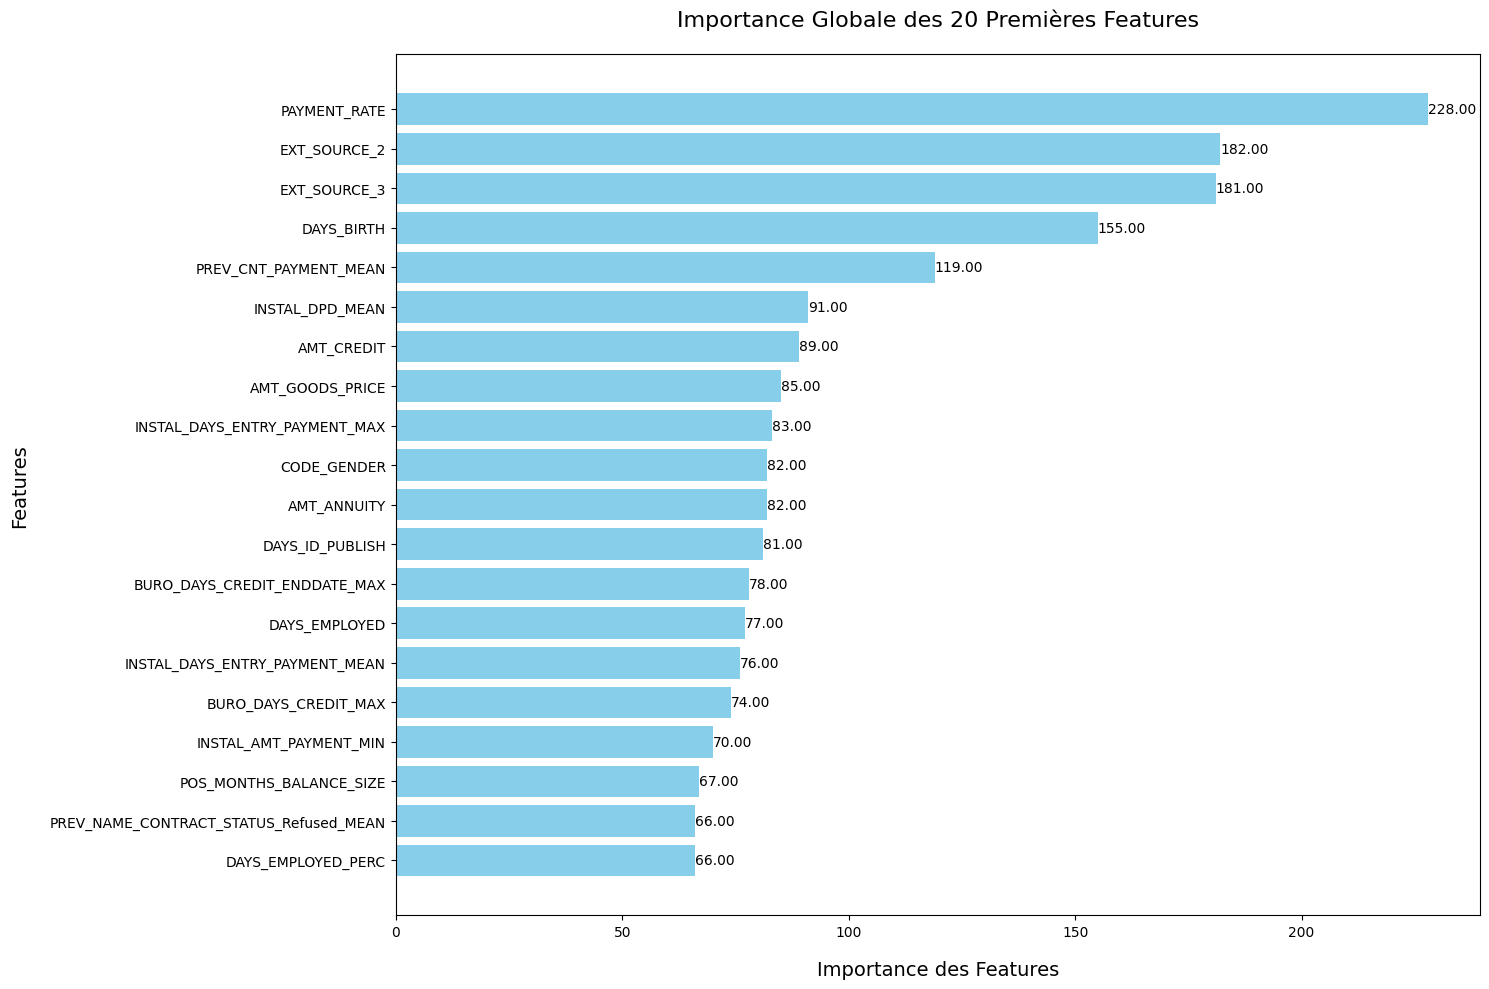

In [43]:
# Définir le nombre de features à afficher
nombre_features = 20

# Trier les features par importance et sélectionner les N premières
features_filtrees = feature_importance_df.sort_values(by='Importance', ascending=False).head(nombre_features)

# Tracer l'importance des features avec étiquettes de valeurs uniquement pour les N premières features
plt.figure(figsize=(15, len(features_filtrees) * 0.5))

bars = plt.barh(features_filtrees['Feature'], features_filtrees['Importance'], color='skyblue')

# Ajouter les étiquettes de valeurs
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', 
             va='center', ha='left', fontsize=10)

# Inverser l'axe des y pour un ordre décroissant
plt.gca().invert_yaxis()

# Ajouter des labels et un titre avec un style amélioré
plt.xlabel("Importance des Features", fontsize=14, labelpad=15)
plt.ylabel("Features", fontsize=14, labelpad=15)
plt.title(f"Importance Globale des {nombre_features} Premières Features", fontsize=16, pad=20)

# Afficher le graphique
plt.tight_layout()
plt.show()


#### ii. Importance features avec Shap

In [46]:
# Créer un explainer SHAP pour le modèle LightGBM
explainer = shap.TreeExplainer(lgbm_model)

# Calculer les valeurs SHAP pour les données d'entraînement
X = df_exp.drop(columns=['TARGET'])
shap_values = explainer.shap_values(X)

# Si shap_values est une liste
if isinstance(shap_values, list):
    shap_values = shap_values[1]  

# Moyenne des valeurs SHAP absolues pour chaque caractéristique (classe positive)
shap_importance = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Importance': np.mean(np.abs(shap_values), axis=0)
})

# Trier les caractéristiques par importance décroissante
shap_importance = shap_importance.sort_values(by='SHAP Importance', ascending=False)


                                            Feature  SHAP Importance
3                             PREV_CNT_PAYMENT_MEAN         0.332171
63                                   INSTAL_DBD_MAX         0.266935
12                                  AMT_GOODS_PRICE         0.191533
2                                      EXT_SOURCE_3         0.177777
28                         BURO_AMT_CREDIT_SUM_MEAN         0.153035
..                                              ...              ...
119  PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN         0.000424
117         PREV_NAME_GOODS_CATEGORY_Computers_MEAN         0.000332
111                                FLAG_DOCUMENT_18         0.000197
109   PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN         0.000192
79   PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN         0.000127

[129 rows x 2 columns]


C:\Users\justi\anaconda3\envs\env_scoring_model\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [47]:
shap_importance

,Feature,SHAP Importance
3,PREV_CNT_PAYMENT_MEAN,0.332171
63,INSTAL_DBD_MAX,0.266935
12,AMT_GOODS_PRICE,0.191533
2,EXT_SOURCE_3,0.177777
28,BURO_AMT_CREDIT_SUM_MEAN,0.153035
...,...,...
119,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,0.000424
117,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,0.000332
111,FLAG_DOCUMENT_18,0.000197
109,PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN,0.000192


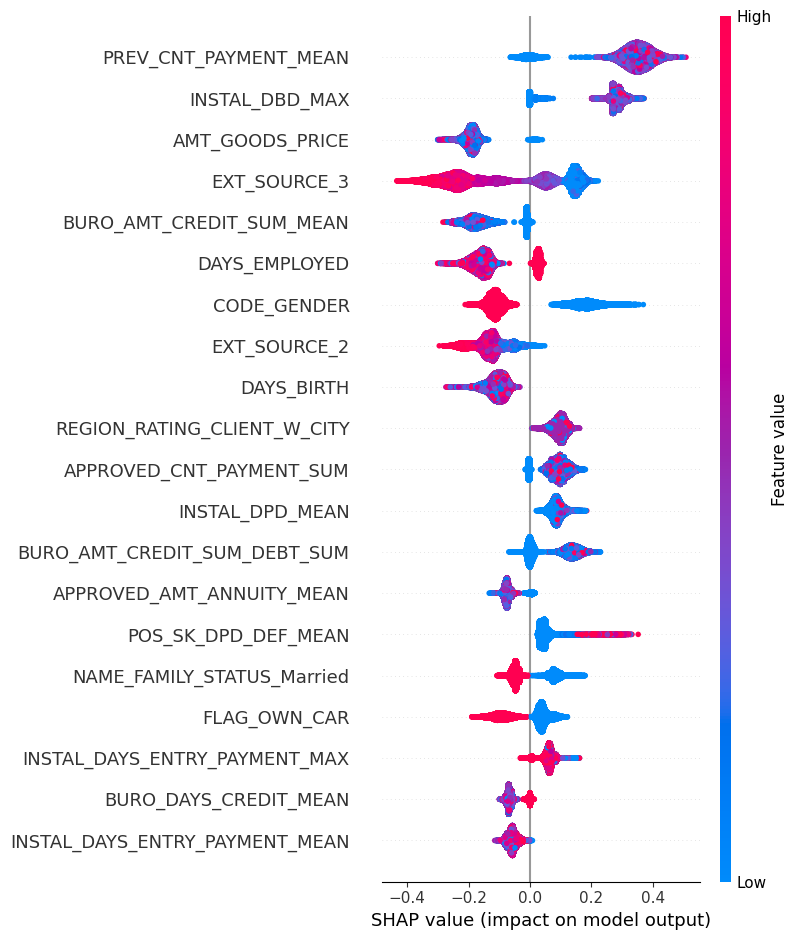

In [48]:
# Visualiser les importances globales avec un summary plot
shap.summary_plot(shap_values, X)

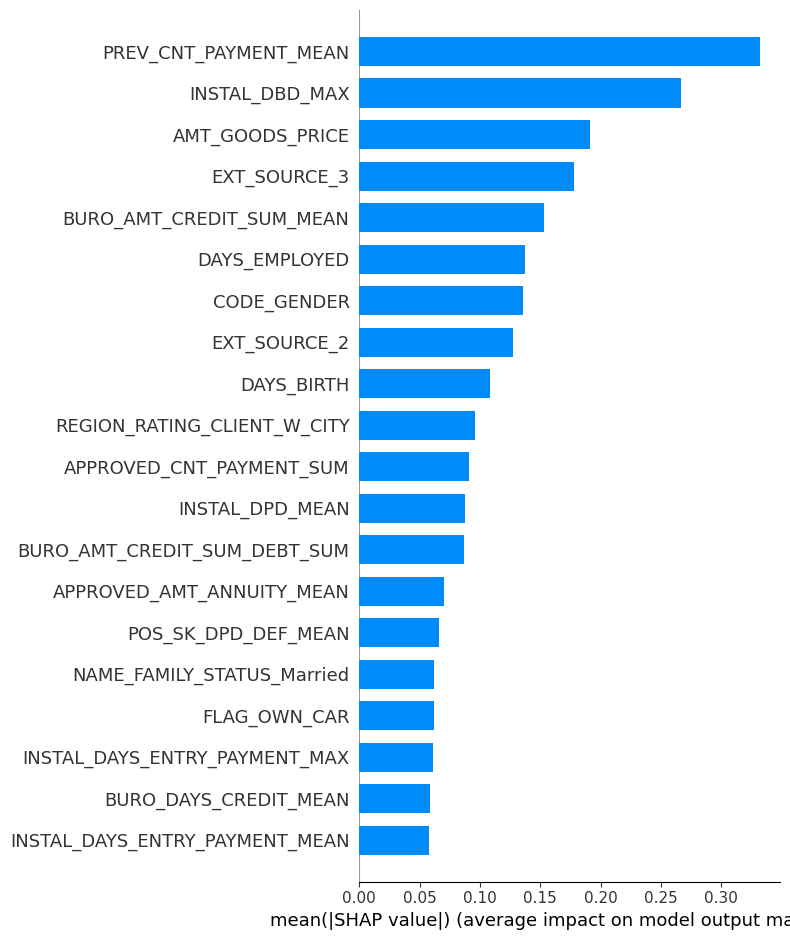

In [49]:
# Graphique en barres des importances moyennes des caractéristiques
shap.summary_plot(shap_values, X, plot_type="bar")

# IV. Data Drift avec Evidently